In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import pandas as pd

## Load data

In [3]:
def readtimes(file):
    times = []; values = []
    with open(file) as f:
        for line in f:
            if 'groups' in line:
                groups = line.replace(',',' ').split()[5:]
            if 'TIME' in line:
                newtime = True
                break
                
        while newtime:
            newtime = False
            times.append(float(line.replace(',',' ').split()[2]))

            values_per_time = []
            for line in f:
                if 'GROUP' in line:
                    continue
                if 'TIME' in line:
                    newtime = True
                    break
                values_per_time.append([float(x) for x in line.strip().split(',') if x != ''])  
            values.append(values_per_time)
        return times, groups, values

In [4]:
times, groups, values = readtimes('group-output-time_mod.csv')

In [5]:
times = np.array(times)
values = np.array(values)

print('# of times: ', len(times))
print('# of groups: ', len(groups))
print('values.shape: ', values.shape)


# of times:  3888
# of groups:  8
values.shape:  (3888, 80, 10)


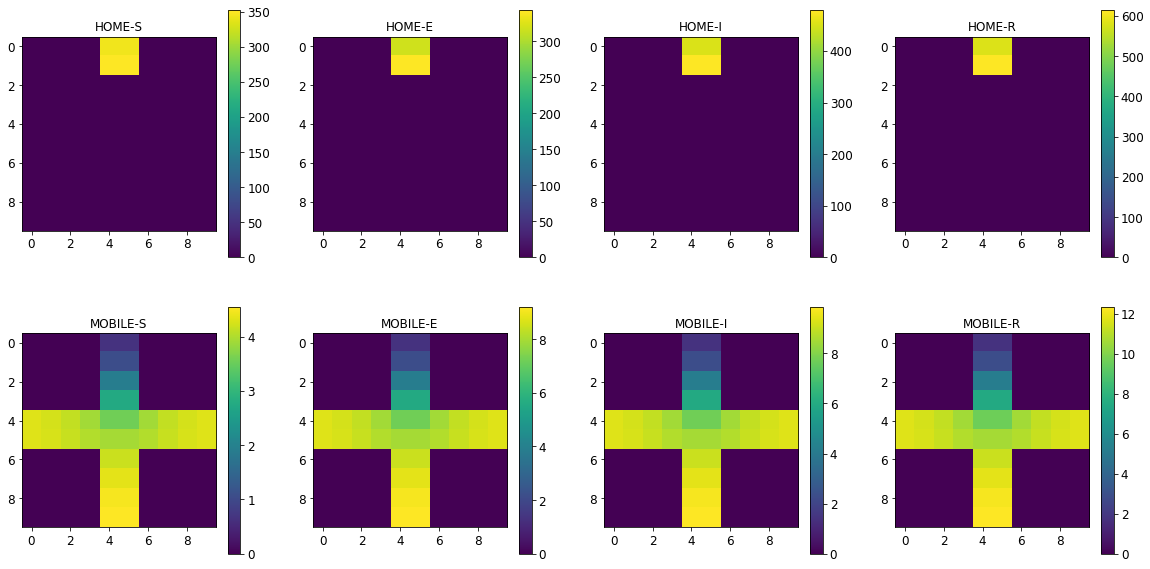

In [6]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(values[3090,i*10:(i+1)*10,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

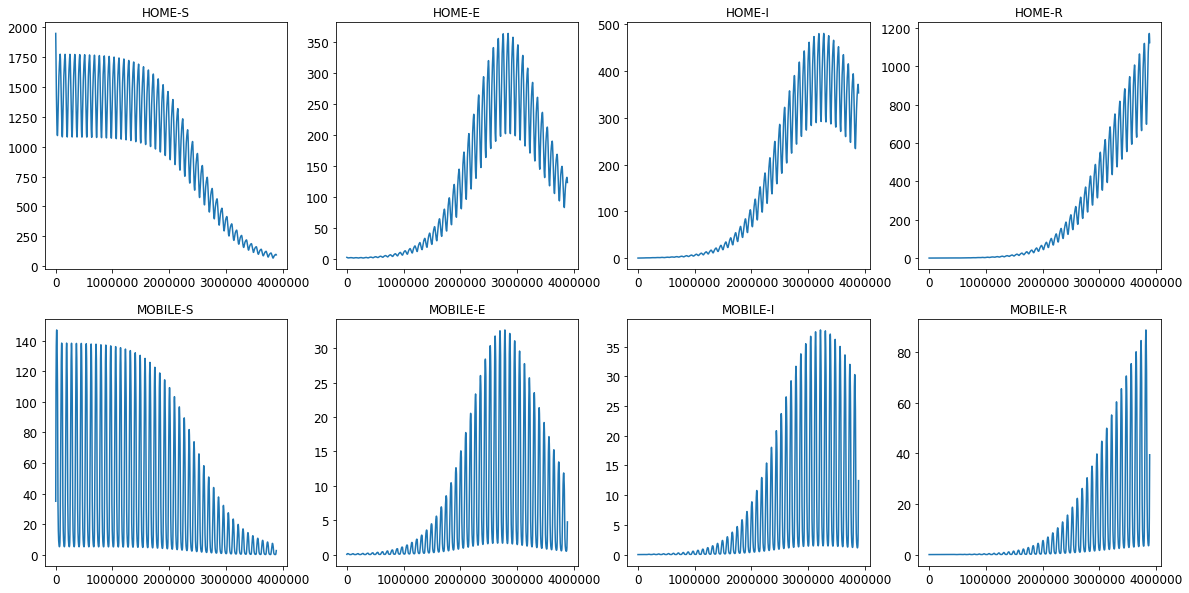

In [7]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, values[:,i*10,4])
    ax.flatten()[i].set_title(group)

## Prepare the data

In [8]:
nl = int(values.shape[-1])
nc = int(values.shape[-2]/len(groups))
print('Grid: ', nl, 'x',nc)

Grid:  10 x 10


In [9]:
X_train_2D = values

In [10]:
X_train_2D.shape

(3888, 80, 10)

In [11]:
X_train_3D = X_train_2D.reshape(len(times),len(groups),nl,nc)

In [12]:
X_train_3D.shape 

(3888, 8, 10, 10)

In [13]:
X_train_1D = X_train_2D.reshape(len(times),len(groups)*nl*nc)

In [14]:
X_train_1D.shape

(3888, 800)

In [15]:
from sklearn.preprocessing import StandardScaler

stdscaler = StandardScaler()

X_train_1D_norm = stdscaler.fit_transform(X_train_1D)
X_train_2D_norm = X_train_1D_norm.reshape(len(times),len(groups)*nl, nc)
X_train_3D_norm = X_train_1D_norm.reshape(len(times),len(groups),nl,nc)

In [16]:
def calculateerror(X_train_3D, X_train_3D_recovered, groups, print_step = 0):
    abs_error = abs(X_train_3D - X_train_3D_recovered)
    perc_error = abs_error*100/abs(X_train_3D)
    
    print('max_abs_error: ',np.max(abs(X_train_3D - X_train_3D_recovered)) )
    print('mean_abs_error: ',np.mean(abs(X_train_3D - X_train_3D_recovered)) )
    
    if print_step:
        for time in range(0,X_train_3D.shape[0],print_step):
            print('\ntime: ',time)
            for i, group in enumerate(groups):
                print('Group '+group+': max_abs_error = ',
                      round(np.max(abs_error[time,i,:,:]) ,4),
                      ' %_mae = ',
                      round( np.max(perc_error[time,i,::][np.isfinite(perc_error[time,i,::])]) ,4),
                      '%')

## Dimensionality reduction - PCA

In [17]:
from sklearn.decomposition import PCA

pca = PCA(X_train_1D.shape[1])
X_train_pca = pca.fit_transform(X_train_1D)

In [18]:
X_recovered = pca.inverse_transform(X_train_pca)
np.allclose(X_recovered, X_train_1D)

True

In [19]:
#print(pca.singular_values_**2/(X_train_1D.shape[0]-1))
#print()
#print(pca.explained_variance_)
#print(pca.explained_variance_ratio_)

In [20]:
p = 0.999
cumsum_eig = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum_eig >= p) + 1
d

6

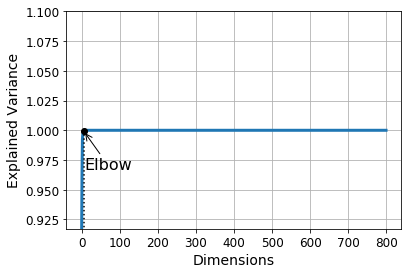

In [21]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_eig, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.ylim([cumsum_eig[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_eig[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [22]:
p = 0.999
cumsum_sv = np.cumsum(pca.singular_values_/sum(pca.singular_values_))
d = np.argmax(cumsum_sv >= p) + 1
d

15

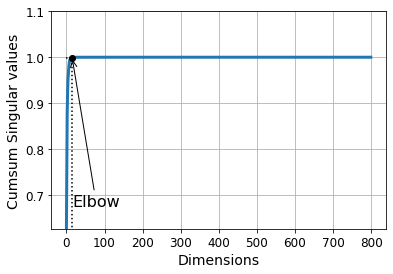

In [23]:
plt.figure(figsize=(6,4))
plt.plot(cumsum_sv, linewidth=3)
plt.xlabel("Dimensions")
plt.ylabel("Cumsum Singular values")
plt.ylim([cumsum_sv[0],1.1])
plt.plot([d, d], [0, p], "k:")
plt.plot([0, d], [p, p], "k:")
plt.plot(d, p, "ko")
plt.annotate("Elbow", xy=(d, p), xytext=(d, cumsum_sv[0]+0.05),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.savefig('pca_normCumSum_singularValues.png')
plt.show()

### Build the model - PCA

In [24]:
pca_compress = PCA(n_components=15)
X_train_pca = pca_compress.fit_transform(X_train_1D)
X_recovered = pca_compress.inverse_transform(X_train_pca)
np.allclose(X_recovered, X_train_1D)

False

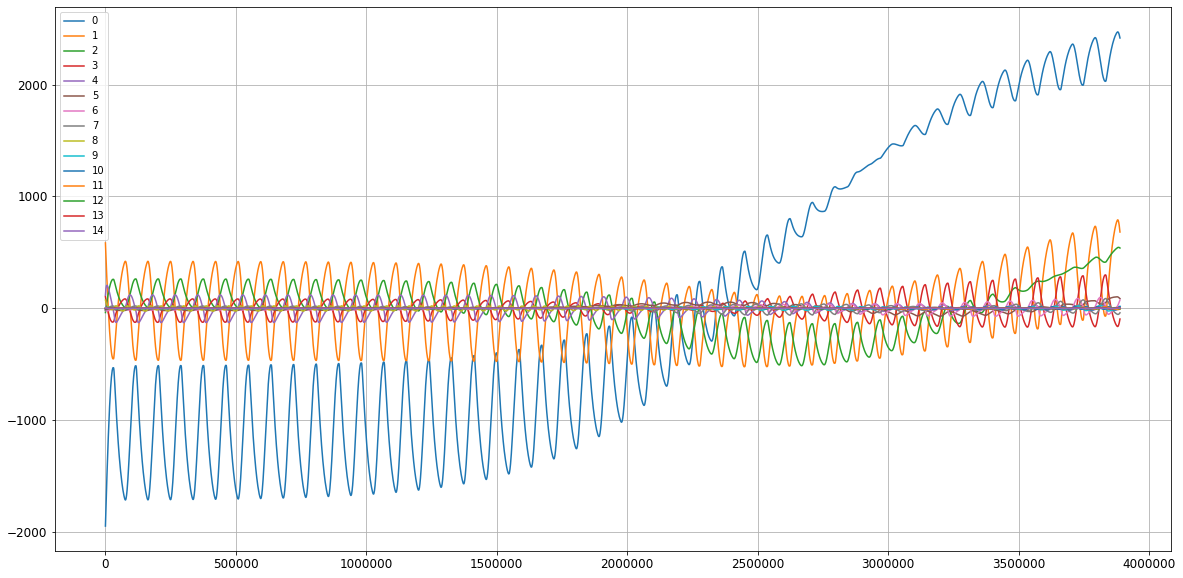

In [25]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_pca);
ax.grid()
ax.legend(range(15))

In [26]:
import joblib
joblib.dump(pca_compress, "pca_compress_15.pkl") 
np.savetxt('X_train_1D.csv', X_train_1D, delimiter=',') 
np.savetxt('X_train_pca.csv', X_train_pca, delimiter=',') 
np.savetxt('times.csv', times, delimiter=',') 
with open('groups.txt','w') as f:
    f.writelines([g + '\n' for g in groups])

#...
# pca_compress = joblib.load("pca_compress_15.pkl") 
# X_train_compressed = np.loadtxt('X_train_pca.csv', delimiter=',') 

# X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
# times  = np.loadtxt('times.csv', delimiter=',') 
# with open('groups.txt') as f:
#     groups = [g.strip() for g in f.readlines()]

# # PCA recovered
# X_recovered = pca_compress.inverse_transform(X_train_compressed)

In [27]:
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_recovered.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  0.9455268950468039
mean_abs_error:  0.003775904514174


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


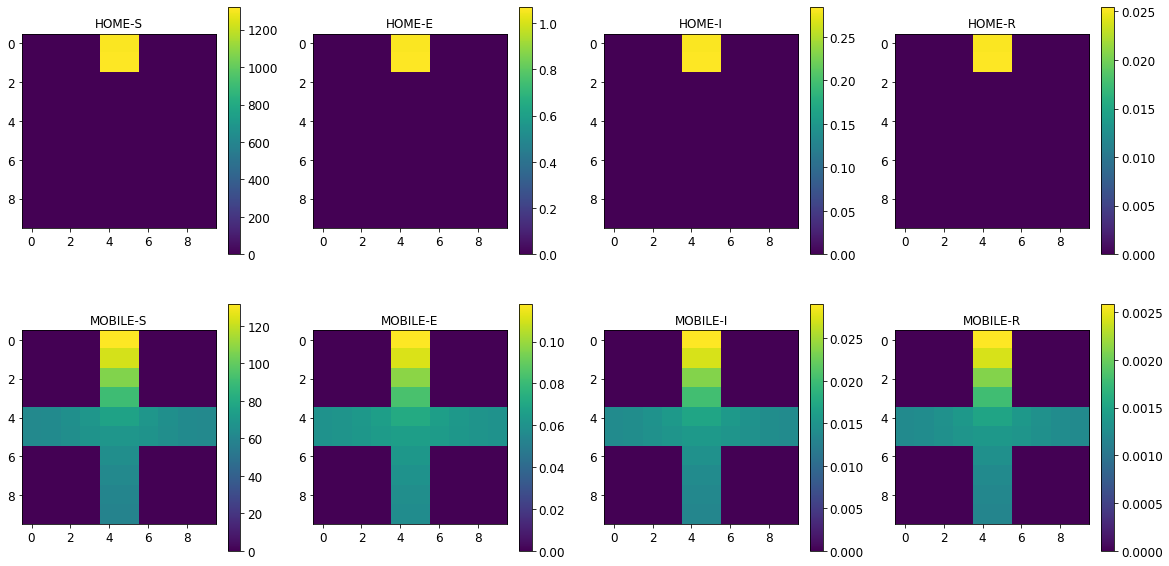

In [28]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_train_1D.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

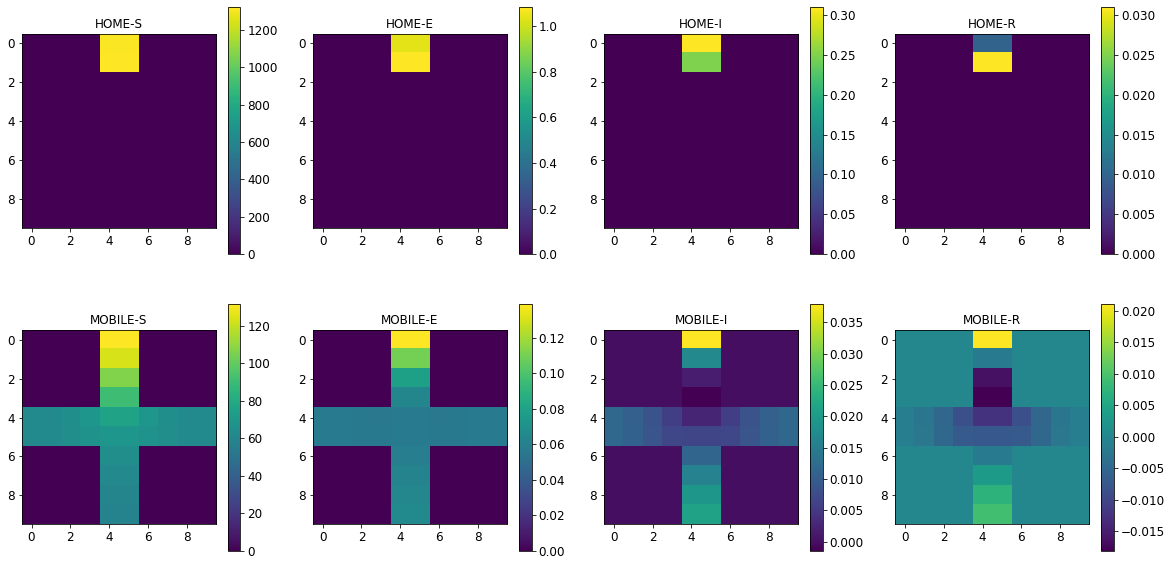

In [29]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_recovered.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

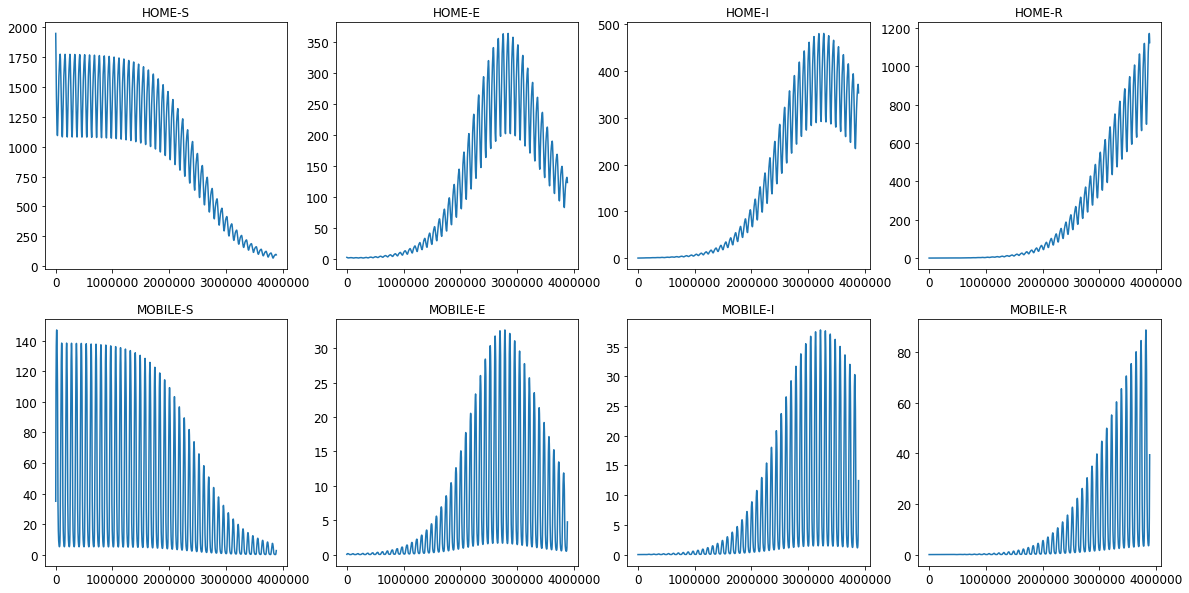

In [30]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

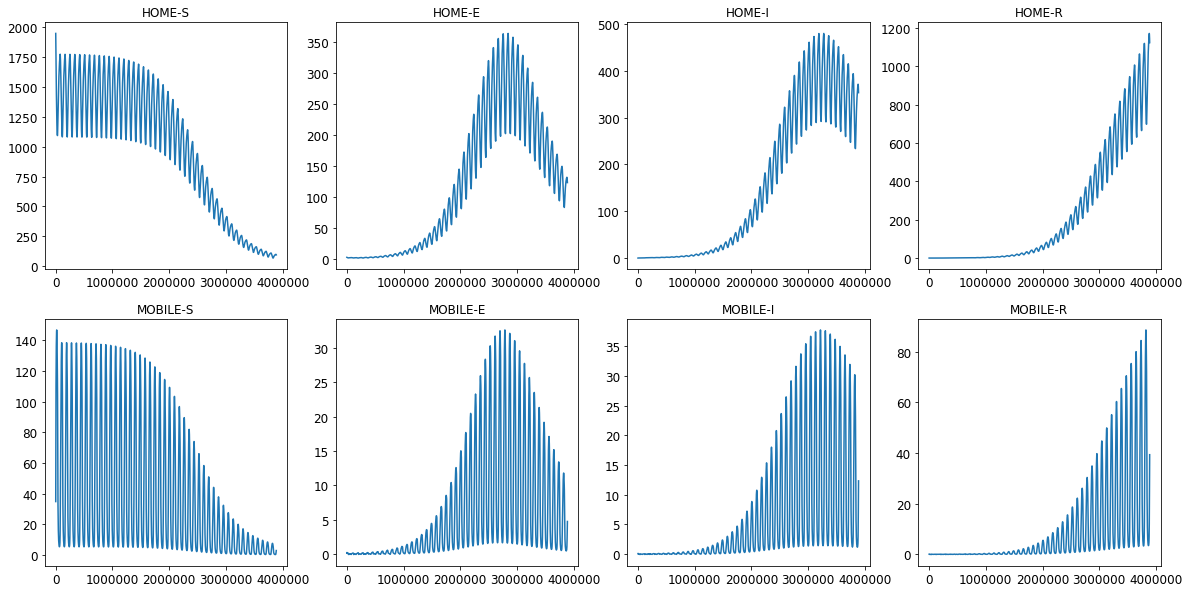

In [31]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_recovered[:,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

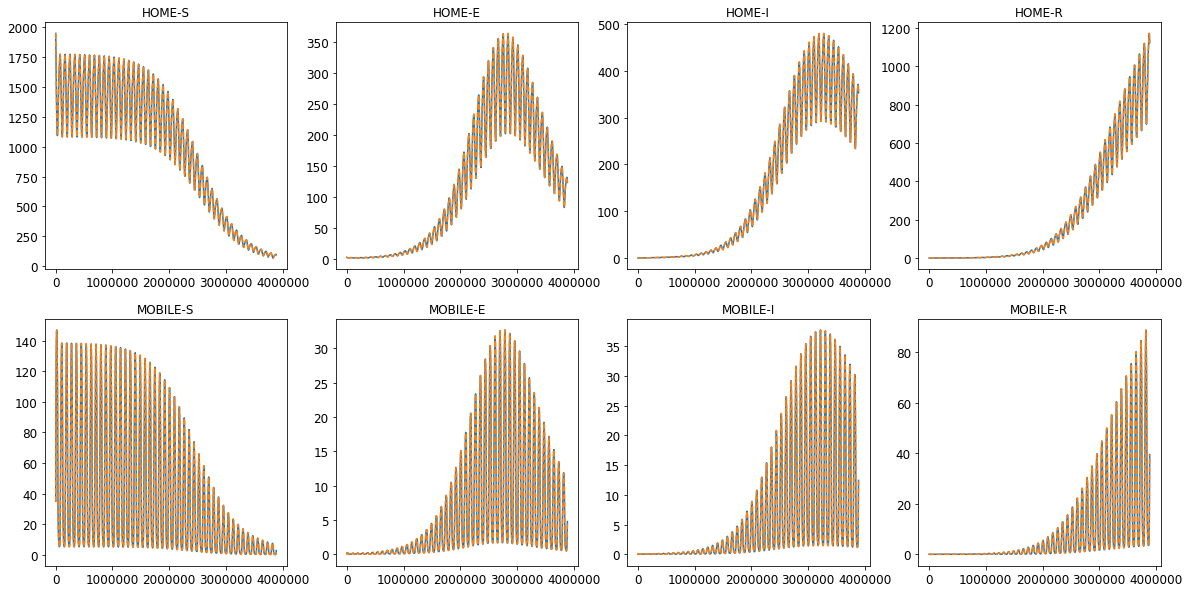

In [32]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_recovered[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)
plt.savefig('pca_compression.png')

## Dimensionality reduction - DEEP AUTOENCODER

### Linear autoencoder

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

encoder = keras.models.Sequential([keras.layers.Dense(15, input_shape=[800])])
decoder = keras.models.Sequential([keras.layers.Dense(800, input_shape=[15])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.Nadam(lr=0.0007, beta_1=0.9, beta_2=0.999)
                    )
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 15)                12015     
_________________________________________________________________
sequential_1 (Sequential)    (None, 800)               12800     
Total params: 24,815
Trainable params: 24,815
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = autoencoder.fit(X_train_1D_norm, 
                          X_train_1D_norm, 
                          epochs=1000,
                          validation_data=(X_train_1D_norm, X_train_1D_norm),
                          callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 1s 284us/sample - loss: 0.0789 - val_loss: 0.0311
Epoch 2/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 0.0196 - val_loss: 0.0143
Epoch 3/1000
3888/3888 [==============================] - 0s 104us/sample - loss: 0.0112 - val_loss: 0.0080
Epoch 4/1000
3888/3888 [==============================] - 0s 107us/sample - loss: 0.0058 - val_loss: 0.0043
Epoch 5/1000
3888/3888 [==============================] - 0s 108us/sample - loss: 0.0034 - val_loss: 0.0028
Epoch 6/1000
3888/3888 [==============================] - 0s 105us/sample - loss: 0.0021 - val_loss: 0.0019
Epoch 7/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 0.0019 - val_loss: 0.0018
Epoch 8/1000
3888/3888 [==============================] - 0s 104us/sample - loss: 0.0018 - val_loss: 0.0017
Epoch 9/1000
3888/3888 [==============================] - 0s 106us/sample - loss: 0.0017

Epoch 141/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 6.7956e-06 - val_loss: 8.0892e-06
Epoch 142/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 7.4466e-06 - val_loss: 5.9785e-06
Epoch 143/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 7.8923e-06 - val_loss: 5.5913e-06
Epoch 144/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 7.6612e-06 - val_loss: 6.7927e-06
Epoch 145/1000
3888/3888 [==============================] - 0s 102us/sample - loss: 3.8833e-05 - val_loss: 5.5189e-06
Epoch 146/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 5.7010e-06 - val_loss: 5.5431e-06
Epoch 147/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 7.0593e-06 - val_loss: 5.7793e-06
Epoch 148/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 4.6730e-05 - val_loss: 1.1371e-05
Epoch 149/1000
3888/3888 [==============================] -

3888/3888 [==============================] - 0s 103us/sample - loss: 4.7815e-06 - val_loss: 4.5568e-06
Epoch 280/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 7.0476e-06 - val_loss: 5.4193e-06
Epoch 281/1000
3888/3888 [==============================] - 0s 104us/sample - loss: 6.2321e-06 - val_loss: 6.5845e-06
Epoch 282/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 2.1679e-05 - val_loss: 4.5588e-06
Epoch 283/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 4.8484e-06 - val_loss: 1.1857e-05
Epoch 284/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 1.1235e-05 - val_loss: 5.2455e-06
Epoch 285/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 5.0642e-06 - val_loss: 5.0168e-06
Epoch 286/1000
3888/3888 [==============================] - 0s 104us/sample - loss: 1.0744e-05 - val_loss: 5.8064e-06
Epoch 287/1000
3888/3888 [==============================] - 0s 103us/sa

3888/3888 [==============================] - 0s 103us/sample - loss: 7.5721e-06 - val_loss: 3.2010e-06
Epoch 418/1000
3888/3888 [==============================] - 0s 105us/sample - loss: 7.2196e-06 - val_loss: 4.1598e-06
Epoch 419/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 2.0746e-05 - val_loss: 3.4600e-06
Epoch 420/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 3.2259e-06 - val_loss: 2.9926e-06
Epoch 421/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 3.4002e-06 - val_loss: 3.2789e-06
Epoch 422/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 4.1587e-06 - val_loss: 3.0755e-06
Epoch 423/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 8.1442e-06 - val_loss: 3.6701e-06
Epoch 424/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 1.0343e-05 - val_loss: 3.1752e-06
Epoch 425/1000
3888/3888 [==============================] - 0s 103us/sa

3888/3888 [==============================] - 0s 100us/sample - loss: 8.9225e-06 - val_loss: 2.2161e-06
Epoch 556/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 2.2146e-06 - val_loss: 2.3061e-06
Epoch 557/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 2.8858e-06 - val_loss: 3.3058e-06
Epoch 558/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 6.7328e-06 - val_loss: 3.8837e-06
Epoch 559/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 6.4267e-06 - val_loss: 2.0716e-06
Epoch 560/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 3.5461e-06 - val_loss: 9.9572e-06
Epoch 561/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 8.2315e-06 - val_loss: 2.1343e-06
Epoch 562/1000
3888/3888 [==============================] - 0s 104us/sample - loss: 7.6250e-06 - val_loss: 2.1587e-06
Epoch 563/1000
3888/3888 [==============================] - 0s 100us/samp

3888/3888 [==============================] - 0s 102us/sample - loss: 2.8043e-06 - val_loss: 2.5965e-06
Epoch 694/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 6.9277e-06 - val_loss: 1.6307e-06
Epoch 695/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 2.6013e-06 - val_loss: 5.7026e-05
Epoch 696/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 4.3196e-06 - val_loss: 3.7107e-05
Epoch 697/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 2.9436e-06 - val_loss: 1.6274e-06
Epoch 698/1000
3888/3888 [==============================] - 0s 105us/sample - loss: 9.2553e-06 - val_loss: 1.0876e-06
Epoch 699/1000
3888/3888 [==============================] - 0s 103us/sample - loss: 1.6584e-06 - val_loss: 1.1857e-06
Epoch 700/1000
3888/3888 [==============================] - 0s 102us/sample - loss: 4.2122e-06 - val_loss: 2.7331e-06
Epoch 701/1000
3888/3888 [==============================] - 0s 99us/samp

3888/3888 [==============================] - 0s 101us/sample - loss: 1.9802e-06 - val_loss: 2.7535e-06
Epoch 832/1000
3888/3888 [==============================] - 0s 99us/sample - loss: 3.9714e-06 - val_loss: 1.0601e-06
Epoch 833/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 2.0874e-06 - val_loss: 1.4974e-06
Epoch 834/1000
3888/3888 [==============================] - 0s 100us/sample - loss: 4.6706e-06 - val_loss: 2.1163e-06
Epoch 835/1000
3888/3888 [==============================] - 0s 102us/sample - loss: 6.9537e-06 - val_loss: 1.2902e-06
Epoch 836/1000
3888/3888 [==============================] - 0s 102us/sample - loss: 1.0588e-06 - val_loss: 2.5100e-06
Epoch 837/1000
3888/3888 [==============================] - 0s 101us/sample - loss: 5.0577e-06 - val_loss: 1.1658e-06
Epoch 838/1000
3888/3888 [==============================] - 0s 102us/sample - loss: 2.1714e-06 - val_loss: 1.0455e-06
Epoch 839/1000
3888/3888 [==============================] - 0s 104us/sam

dict_keys(['loss', 'val_loss'])
best value:  9.154292058142889e-07


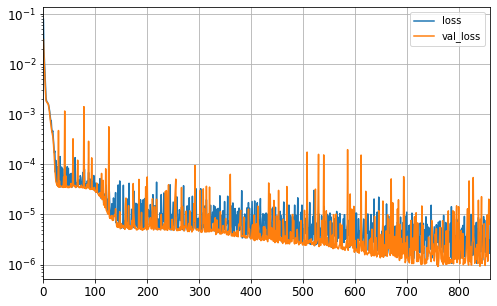

In [32]:
print(history.history.keys())
print('best value: ', autoencoder.evaluate(X_train_1D_norm, X_train_1D_norm, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [33]:
X_reconstructions = autoencoder.predict(X_train_1D_norm)
X_reconstructions = stdscaler.inverse_transform(X_reconstructions)

In [34]:
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  14.3992919921875
mean_abs_error:  0.02822514491985846


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


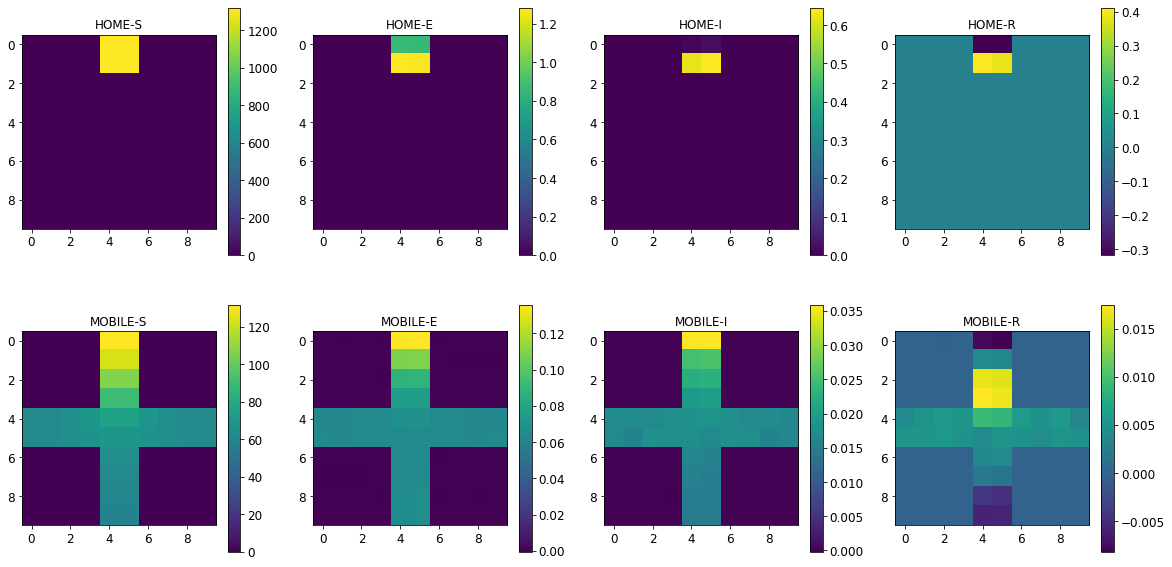

In [35]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

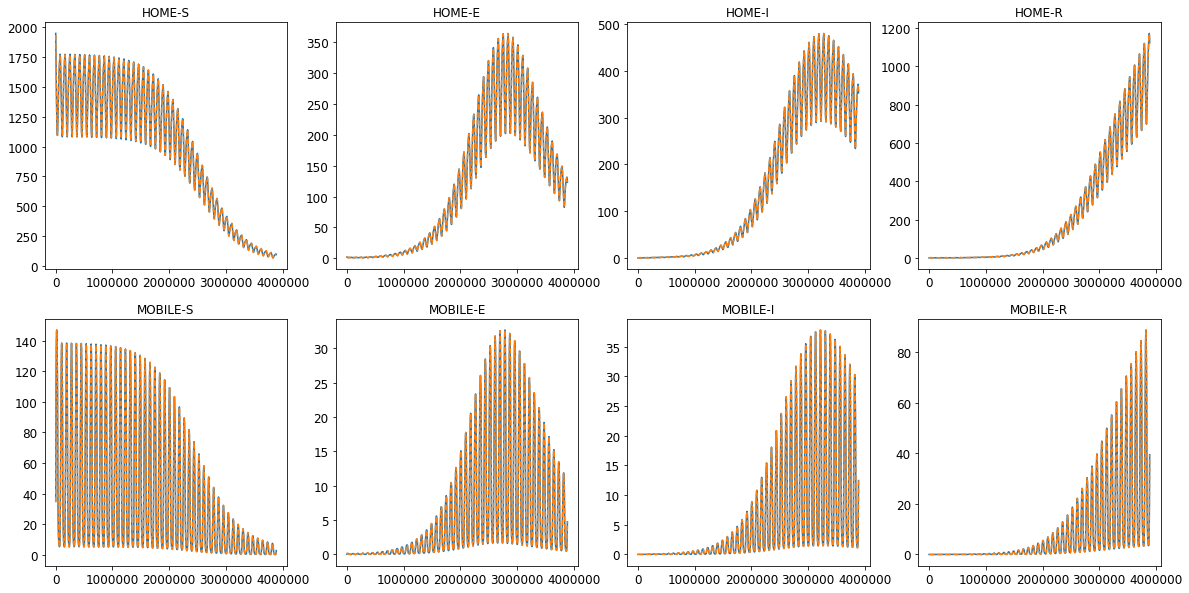

In [36]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

encoder = keras.models.Sequential([keras.layers.Dense(200, input_shape=[800]),
                                   keras.layers.Dense(15)])
decoder = keras.models.Sequential([keras.layers.Dense(200, input_shape=[15]),
                                   keras.layers.Dense(800),
                                  ])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999)
                    )
encoder.summary()
decoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 200)               160200    
_________________________________________________________________
dense_3 (Dense)              (None, 15)                3015      
Total params: 163,215
Trainable params: 163,215
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 200)               3200      
_________________________________________________________________
dense_5 (Dense)              (None, 800)               160800    
Total params: 164,000
Trainable params: 164,000
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = autoencoder.fit(X_train_1D_norm, 
                          X_train_1D_norm, 
                          epochs=1000,
                          validation_data=(X_train_1D_norm, X_train_1D_norm),
                          callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 1s 335us/sample - loss: 0.0535 - val_loss: 0.0152
Epoch 2/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 0.0083 - val_loss: 0.0040
Epoch 3/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 0.0029 - val_loss: 0.0019
Epoch 4/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 0.0019 - val_loss: 0.0017
Epoch 5/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 0.0018 - val_loss: 0.0019
Epoch 6/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 0.0016 - val_loss: 0.0012
Epoch 7/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 0.0013 - val_loss: 7.5517e-04
Epoch 8/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 5.8562e-04 - val_loss: 4.4975e-04
Epoch 9/1000
3888/3888 [==============================] - 1s 166us/sample - 

Epoch 141/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 2.3423e-05 - val_loss: 5.6475e-05
Epoch 142/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 9.1158e-06 - val_loss: 5.5077e-06
Epoch 143/1000
3888/3888 [==============================] - 1s 177us/sample - loss: 1.2764e-05 - val_loss: 4.9976e-06
Epoch 144/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 1.2453e-05 - val_loss: 8.4360e-06
Epoch 145/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 3.0160e-05 - val_loss: 4.5491e-06
Epoch 146/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 7.5740e-06 - val_loss: 4.5006e-06
Epoch 147/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 3.7311e-05 - val_loss: 5.0322e-06
Epoch 148/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 2.3695e-05 - val_loss: 3.8241e-05
Epoch 149/1000
3888/3888 [==============================

3888/3888 [==============================] - 1s 171us/sample - loss: 4.1505e-06 - val_loss: 4.8731e-06
Epoch 280/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 2.8524e-05 - val_loss: 4.0713e-06
Epoch 281/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 3.4387e-06 - val_loss: 2.7308e-06
Epoch 282/1000
3888/3888 [==============================] - 1s 163us/sample - loss: 4.2541e-06 - val_loss: 2.6044e-06
Epoch 283/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 1.1921e-05 - val_loss: 7.5142e-04
Epoch 284/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 3.0587e-05 - val_loss: 2.9926e-06
Epoch 285/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 2.5475e-06 - val_loss: 2.3648e-06
Epoch 286/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 2.5947e-06 - val_loss: 4.1283e-06
Epoch 287/1000
3888/3888 [==============================] - 1s 171us/sa

3888/3888 [==============================] - 1s 177us/sample - loss: 3.5351e-05 - val_loss: 3.3211e-06
Epoch 418/1000
3888/3888 [==============================] - 1s 185us/sample - loss: 1.4503e-06 - val_loss: 1.1680e-06
Epoch 419/1000
3888/3888 [==============================] - 1s 178us/sample - loss: 1.6460e-06 - val_loss: 1.2937e-06
Epoch 420/1000
3888/3888 [==============================] - 1s 177us/sample - loss: 1.6762e-06 - val_loss: 1.3255e-06
Epoch 421/1000
3888/3888 [==============================] - 1s 177us/sample - loss: 1.1399e-05 - val_loss: 1.5501e-06
Epoch 422/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 3.0778e-06 - val_loss: 1.1850e-06
Epoch 423/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 1.0573e-05 - val_loss: 1.7515e-05
Epoch 424/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 4.0132e-06 - val_loss: 1.3778e-06
Epoch 425/1000
3888/3888 [==============================] - 1s 170us/sa

3888/3888 [==============================] - 1s 168us/sample - loss: 5.1350e-06 - val_loss: 2.8627e-06
Epoch 556/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 6.1295e-06 - val_loss: 1.0613e-06
Epoch 557/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 2.1084e-06 - val_loss: 1.9802e-06
Epoch 558/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 9.0013e-06 - val_loss: 3.9983e-05
Epoch 559/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 1.1063e-05 - val_loss: 2.9720e-06
Epoch 560/1000
3888/3888 [==============================] - 1s 175us/sample - loss: 2.2798e-06 - val_loss: 1.1325e-06
Epoch 561/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 4.1539e-06 - val_loss: 6.9933e-07
Epoch 562/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 5.8772e-06 - val_loss: 1.5867e-06
Epoch 563/1000
3888/3888 [==============================] - 1s 174us/sa

3888/3888 [==============================] - 1s 172us/sample - loss: 8.6873e-06 - val_loss: 8.5413e-07
Epoch 694/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 8.3717e-06 - val_loss: 2.9855e-06
Epoch 695/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 2.1306e-06 - val_loss: 7.3996e-06
Epoch 696/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 6.3075e-06 - val_loss: 5.7341e-05
Epoch 697/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 6.8246e-06 - val_loss: 5.8163e-07
Epoch 698/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 6.7242e-06 - val_loss: 7.4032e-07
Epoch 699/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 1.4336e-06 - val_loss: 1.0061e-06
Epoch 700/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 1.2117e-05 - val_loss: 2.3619e-06
Epoch 701/1000
3888/3888 [==============================] - 1s 170us/sa

3888/3888 [==============================] - 1s 170us/sample - loss: 2.9628e-06 - val_loss: 2.0404e-06
Epoch 832/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 5.4720e-06 - val_loss: 9.3301e-07
Epoch 833/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 1.7215e-06 - val_loss: 3.0003e-06
Epoch 834/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 2.0808e-05 - val_loss: 7.2190e-07
Epoch 835/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 8.8221e-07 - val_loss: 7.6455e-07
Epoch 836/1000
3888/3888 [==============================] - 1s 177us/sample - loss: 1.6198e-06 - val_loss: 1.0451e-05
Epoch 00836: early stopping


dict_keys(['loss', 'val_loss'])
best value:  5.652084395026656e-07


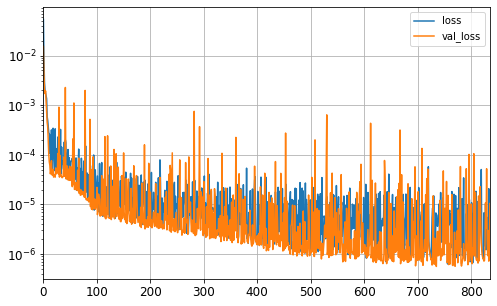

In [39]:
print(history.history.keys())
print('best value: ', autoencoder.evaluate(X_train_1D_norm, X_train_1D_norm, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [40]:
X_reconstructions = autoencoder.predict(X_train_1D_norm)
X_reconstructions = stdscaler.inverse_transform(X_reconstructions)

In [41]:
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  5.275390625
mean_abs_error:  0.015190057506593278


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


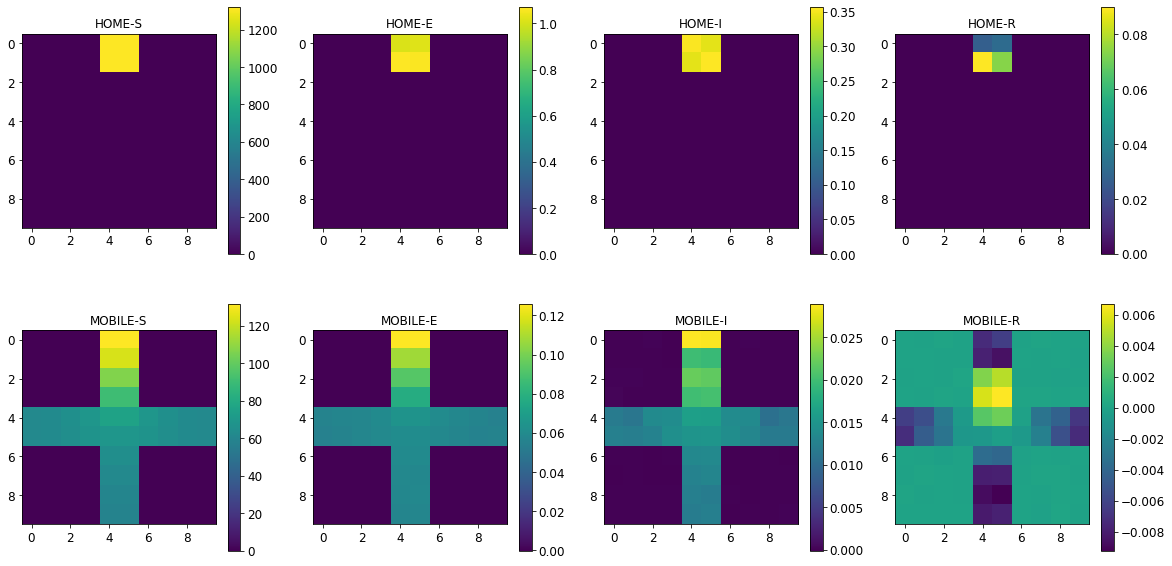

In [42]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

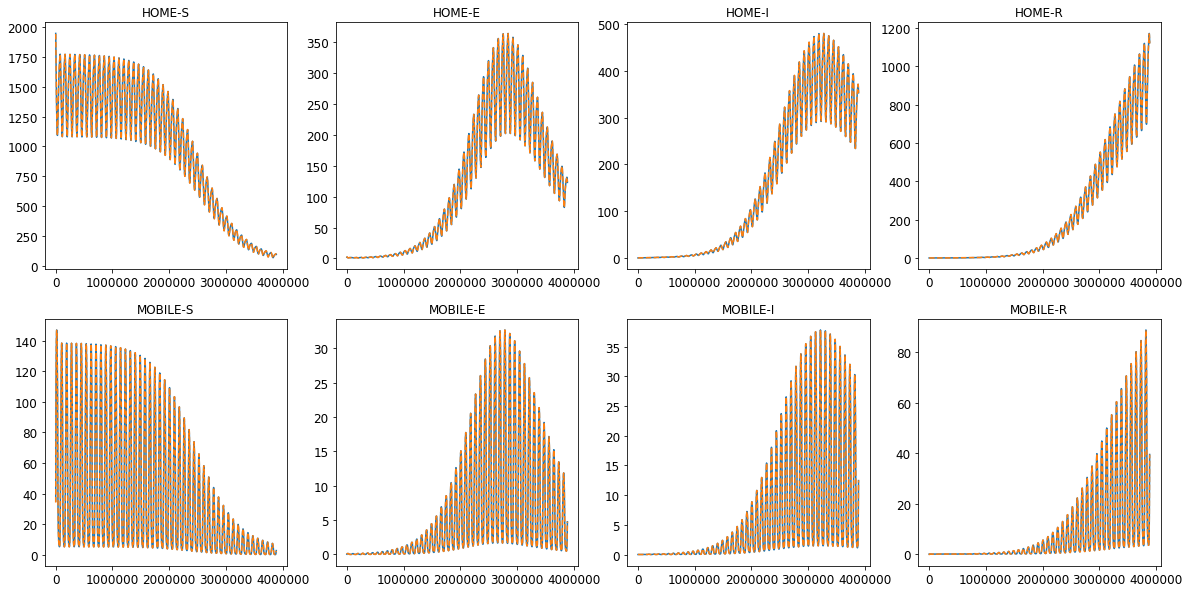

In [43]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

### Non-linear autoencoder

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

encoder = keras.models.Sequential([keras.layers.Dense(100, input_shape=[800], activation="elu"),
                                   keras.layers.Dense(50, activation="elu"),
                                   keras.layers.Dense(15)])
decoder = keras.models.Sequential([keras.layers.Dense(50, input_shape=[15], activation="elu"),
                                   keras.layers.Dense(100, activation="elu"),
                                   keras.layers.Dense(800),
                                  ])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999)
                    )
encoder.summary()
decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 100)               80100     
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 15)                765       
Total params: 85,915
Trainable params: 85,915
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 50)                800       
_________________________________________________________________
dense_10 (Dense)             (None, 100)               5100      
____________________________

In [45]:
history = autoencoder.fit(X_train_1D_norm, 
                          X_train_1D_norm, 
                          epochs=1000,
                          validation_data=(X_train_1D_norm, X_train_1D_norm),
                          callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 2s 399us/sample - loss: 0.0738 - val_loss: 0.0213
Epoch 2/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 0.0133 - val_loss: 0.0077
Epoch 3/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 0.0052 - val_loss: 0.0039
Epoch 4/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 0.0028 - val_loss: 0.0019
Epoch 5/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 0.0016 - val_loss: 0.0014
Epoch 6/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 0.0011 - val_loss: 9.0248e-04
Epoch 7/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 8.9075e-04 - val_loss: 8.0369e-04
Epoch 8/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 6.9541e-04 - val_loss: 5.6254e-04
Epoch 9/1000
3888/3888 [==============================] - 1s 177us/s

3888/3888 [==============================] - 1s 164us/sample - loss: 2.5326e-05 - val_loss: 2.0978e-05
Epoch 72/1000
3888/3888 [==============================] - 1s 165us/sample - loss: 3.6382e-05 - val_loss: 2.2463e-05
Epoch 73/1000
3888/3888 [==============================] - 1s 163us/sample - loss: 5.5984e-05 - val_loss: 2.4758e-05
Epoch 74/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 2.9602e-05 - val_loss: 2.2974e-05
Epoch 75/1000
3888/3888 [==============================] - 1s 165us/sample - loss: 5.0904e-05 - val_loss: 2.1345e-05
Epoch 76/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 2.3756e-05 - val_loss: 2.2046e-05
Epoch 77/1000
3888/3888 [==============================] - 1s 162us/sample - loss: 4.9396e-05 - val_loss: 5.9935e-05
Epoch 78/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 4.3136e-05 - val_loss: 2.0602e-05
Epoch 79/1000
3888/3888 [==============================] - 1s 168us/sample - l

Epoch 141/1000
3888/3888 [==============================] - 1s 168us/sample - loss: 1.5385e-05 - val_loss: 2.9868e-05
Epoch 142/1000
3888/3888 [==============================] - 1s 168us/sample - loss: 1.9851e-05 - val_loss: 7.6551e-06
Epoch 143/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 2.8339e-05 - val_loss: 7.6110e-06
Epoch 144/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 9.5839e-06 - val_loss: 9.5788e-06
Epoch 145/1000
3888/3888 [==============================] - 1s 168us/sample - loss: 2.5811e-05 - val_loss: 8.3010e-06
Epoch 146/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 1.0925e-05 - val_loss: 9.0989e-06
Epoch 147/1000
3888/3888 [==============================] - 1s 169us/sample - loss: 1.8010e-05 - val_loss: 1.3611e-05
Epoch 148/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 2.8578e-05 - val_loss: 6.2824e-05
Epoch 149/1000
3888/3888 [==============================

3888/3888 [==============================] - 1s 167us/sample - loss: 6.4102e-06 - val_loss: 6.3642e-06
Epoch 280/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 2.2950e-05 - val_loss: 9.8561e-06
Epoch 281/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 6.4483e-06 - val_loss: 5.0064e-06
Epoch 282/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 1.0415e-05 - val_loss: 3.8922e-06
Epoch 283/1000
3888/3888 [==============================] - 1s 157us/sample - loss: 7.3388e-06 - val_loss: 2.8215e-05
Epoch 284/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 1.9822e-05 - val_loss: 4.6206e-06
Epoch 285/1000
3888/3888 [==============================] - 1s 165us/sample - loss: 8.4450e-06 - val_loss: 6.4214e-06
Epoch 286/1000
3888/3888 [==============================] - 1s 168us/sample - loss: 5.0932e-06 - val_loss: 9.2331e-06
Epoch 287/1000
3888/3888 [==============================] - 1s 165us/sa

3888/3888 [==============================] - 1s 168us/sample - loss: 1.9901e-05 - val_loss: 3.5244e-06
Epoch 418/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 3.1827e-06 - val_loss: 3.2904e-06
Epoch 419/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 4.8657e-06 - val_loss: 1.0701e-05
Epoch 420/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 5.7142e-06 - val_loss: 3.1441e-06
Epoch 421/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 1.0619e-05 - val_loss: 3.3862e-06
Epoch 422/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 4.3337e-06 - val_loss: 3.6045e-06
Epoch 423/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 1.1331e-05 - val_loss: 1.8343e-05
Epoch 424/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 2.2488e-05 - val_loss: 4.6157e-06
Epoch 425/1000
3888/3888 [==============================] - 1s 167us/sa

3888/3888 [==============================] - 1s 175us/sample - loss: 1.9009e-05 - val_loss: 5.3621e-06
Epoch 556/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 3.6942e-06 - val_loss: 4.2823e-06
Epoch 557/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 5.6321e-06 - val_loss: 2.9906e-06
Epoch 558/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 4.9592e-06 - val_loss: 3.2649e-06
Epoch 559/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 1.1233e-05 - val_loss: 3.9317e-06
Epoch 560/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 8.3850e-06 - val_loss: 4.1759e-06
Epoch 561/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 3.1517e-06 - val_loss: 2.4860e-06
Epoch 562/1000
3888/3888 [==============================] - 1s 167us/sample - loss: 8.5320e-06 - val_loss: 3.1471e-06
Epoch 563/1000
3888/3888 [==============================] - 1s 162us/sa

3888/3888 [==============================] - 1s 164us/sample - loss: 6.4126e-06 - val_loss: 5.5727e-06
Epoch 694/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 8.7468e-06 - val_loss: 2.6840e-06
Epoch 695/1000
3888/3888 [==============================] - 1s 161us/sample - loss: 6.7808e-06 - val_loss: 1.6310e-04
Epoch 696/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 1.1829e-05 - val_loss: 3.1340e-06
Epoch 697/1000
3888/3888 [==============================] - 1s 166us/sample - loss: 2.4261e-06 - val_loss: 2.6237e-06
Epoch 698/1000
3888/3888 [==============================] - 1s 160us/sample - loss: 3.5702e-06 - val_loss: 1.9178e-06
Epoch 699/1000
3888/3888 [==============================] - 1s 160us/sample - loss: 7.4502e-06 - val_loss: 3.7225e-06
Epoch 700/1000
3888/3888 [==============================] - 1s 164us/sample - loss: 7.0083e-06 - val_loss: 1.2410e-05
Epoch 701/1000
3888/3888 [==============================] - 1s 160us/sa

3888/3888 [==============================] - 1s 168us/sample - loss: 2.0182e-06 - val_loss: 2.2805e-06
Epoch 832/1000
3888/3888 [==============================] - 1s 172us/sample - loss: 3.0929e-06 - val_loss: 2.1839e-06
Epoch 833/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 6.7647e-06 - val_loss: 7.4611e-06
Epoch 834/1000
3888/3888 [==============================] - 1s 170us/sample - loss: 5.8294e-06 - val_loss: 2.1110e-06
Epoch 835/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 8.6005e-06 - val_loss: 2.5510e-06
Epoch 836/1000
3888/3888 [==============================] - 1s 174us/sample - loss: 2.1009e-06 - val_loss: 4.8268e-06
Epoch 837/1000
3888/3888 [==============================] - 1s 173us/sample - loss: 7.8965e-06 - val_loss: 6.7347e-06
Epoch 838/1000
3888/3888 [==============================] - 1s 171us/sample - loss: 6.3969e-06 - val_loss: 2.3511e-06
Epoch 839/1000
3888/3888 [==============================] - 1s 171us/sa

dict_keys(['loss', 'val_loss'])
best value:  1.3029401012924306e-06


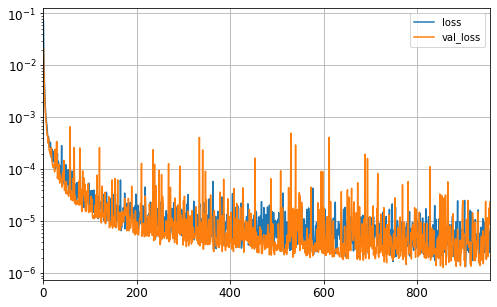

In [46]:
print(history.history.keys())
print('best value: ', autoencoder.evaluate(X_train_1D_norm, X_train_1D_norm, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [47]:
X_reconstructions = autoencoder.predict(X_train_1D_norm)
X_reconstructions = stdscaler.inverse_transform(X_reconstructions)

In [48]:
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  11.947998046875
mean_abs_error:  0.018922157238844824


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


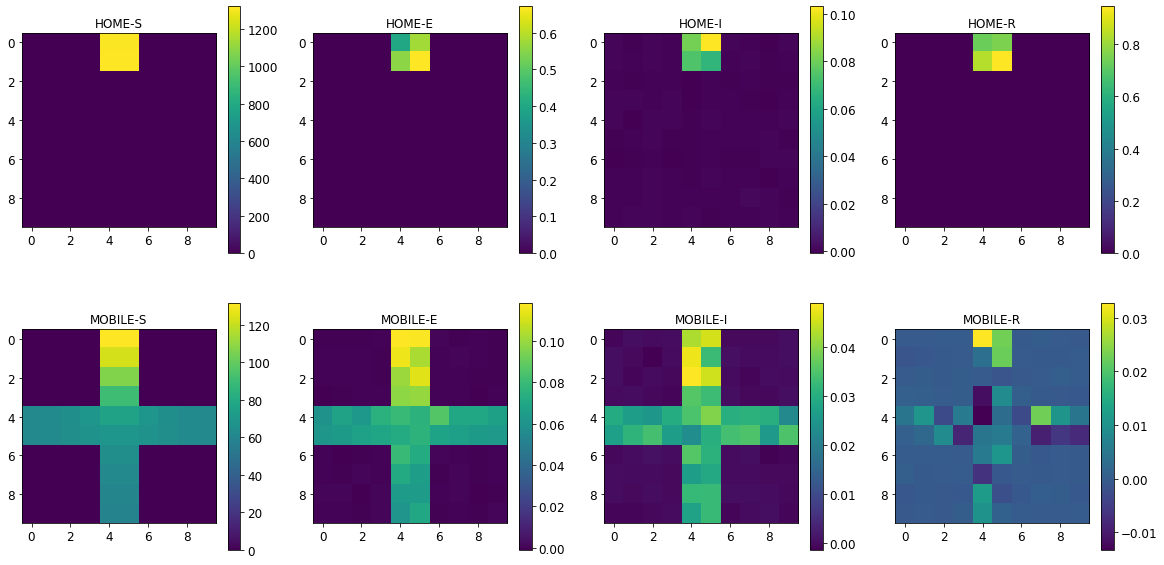

In [49]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

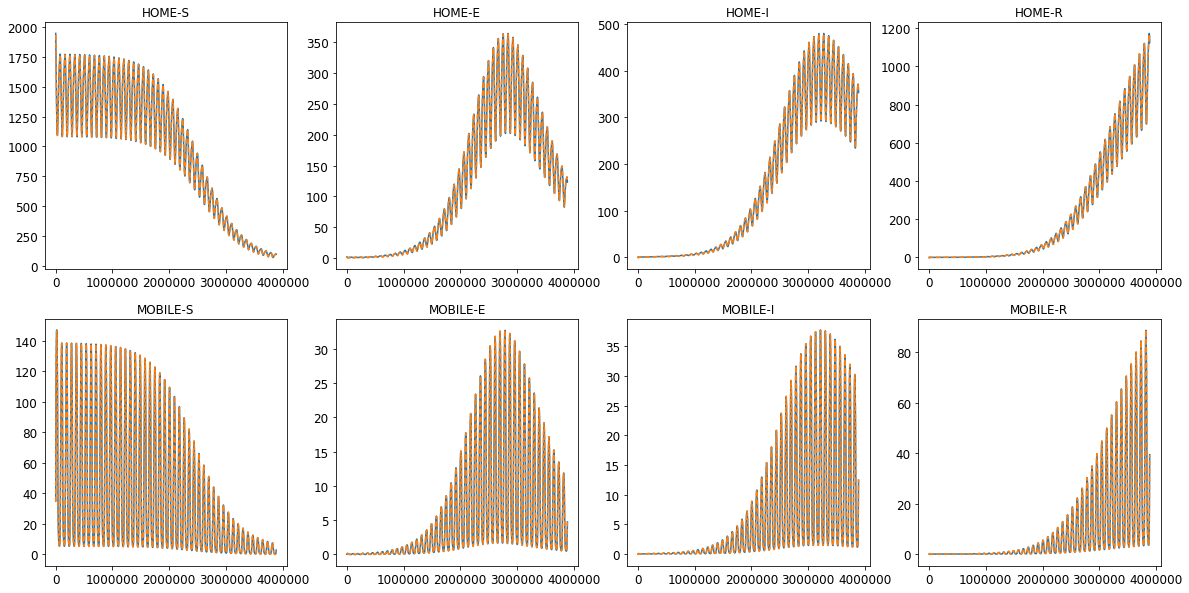

In [50]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

### PCA Non-linear autoencoder

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=115)
X_train_pca = pca.fit_transform(X_train_1D)

In [52]:
for i, s in enumerate(pca.singular_values_):
    print(i,s)

0 80968.84766232983
1 18736.416256363147
2 13673.705906493908
3 5582.676911420286
4 3850.103044758365
5 1800.019343080367
6 1528.5522031979297
7 1280.5509296354314
8 732.9460285895258
9 435.26801371011277
10 297.1644606962294
11 181.60261273092226
12 87.67587246299661
13 64.75204695667632
14 56.14576255903517
15 22.805565355182708
16 14.680854372754887
17 9.433904365360851
18 8.086013100546879
19 6.691068654905932
20 3.580681950463192
21 3.20088686807251
22 2.9496893087417306
23 1.3593700244681008
24 1.303570351076243
25 0.9841955380229419
26 0.8745552427561293
27 0.6751953659028838
28 0.45335331999123346
29 0.3682248610588608
30 0.34029883857464993
31 0.30108410171505134
32 0.2747720601623404
33 0.2580691302875648
34 0.25155019818685037
35 0.23908841104002337
36 0.231200546275467
37 0.2264119861037694
38 0.2231818070561315
39 0.22132948289422547
40 0.21754946426500482
41 0.1964041659361343
42 0.1679801080275365
43 0.15181483405154386
44 0.14977231392571658
45 0.1473383360201773
46 0.1

In [53]:
np.random.seed(42)
tf.random.set_seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

encoder = keras.models.Sequential([keras.layers.Dense(100, input_shape=[115], activation="elu"),
                                   keras.layers.Dense(50, activation="elu"),
                                   keras.layers.Dense(15)])
decoder = keras.models.Sequential([keras.layers.Dense(50, input_shape=[15], activation="elu"),
                                   keras.layers.Dense(100, activation="elu"),
                                   keras.layers.Dense(115),
                                  ])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", 
                    optimizer=keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999)
                    )
encoder.summary()
decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 100)               11600     
_________________________________________________________________
dense_13 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_14 (Dense)             (None, 15)                765       
Total params: 17,415
Trainable params: 17,415
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 50)                800       
_________________________________________________________________
dense_16 (Dense)             (None, 100)               5100      
___________________________

In [54]:
history = autoencoder.fit(X_train_pca, 
                          X_train_pca, 
                          epochs=1000,
                          validation_data=(X_train_pca, X_train_pca),
                          callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 1s 350us/sample - loss: 8216.8399 - val_loss: 1035.5376
Epoch 2/1000
3888/3888 [==============================] - 0s 109us/sample - loss: 734.8472 - val_loss: 478.6631
Epoch 3/1000
3888/3888 [==============================] - 0s 108us/sample - loss: 287.6702 - val_loss: 164.8730
Epoch 4/1000
3888/3888 [==============================] - 0s 105us/sample - loss: 114.3151 - val_loss: 85.6140
Epoch 5/1000
3888/3888 [==============================] - 0s 108us/sample - loss: 74.4078 - val_loss: 64.5016
Epoch 6/1000
3888/3888 [==============================] - 0s 108us/sample - loss: 56.8069 - val_loss: 48.2749
Epoch 7/1000
3888/3888 [==============================] - 0s 107us/sample - loss: 39.9972 - val_loss: 31.4465
Epoch 8/1000
3888/3888 [==============================] - 0s 107us/sample - loss: 27.3115 - val_loss: 26.8397
Epoch 9/1000
3888/3888 [==============================] - 0s 10

Epoch 150/1000
3888/3888 [==============================] - 0s 113us/sample - loss: 0.6620 - val_loss: 2.3189
Epoch 151/1000
3888/3888 [==============================] - 0s 110us/sample - loss: 1.0340 - val_loss: 0.9976
Epoch 152/1000
3888/3888 [==============================] - 0s 113us/sample - loss: 0.9673 - val_loss: 0.4628
Epoch 153/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.6260 - val_loss: 0.5743
Epoch 154/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.6380 - val_loss: 0.5684
Epoch 155/1000
3888/3888 [==============================] - 0s 111us/sample - loss: 0.6946 - val_loss: 1.1423
Epoch 156/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.7326 - val_loss: 0.4652
Epoch 157/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 1.0057 - val_loss: 6.7324
Epoch 158/1000
3888/3888 [==============================] - 0s 109us/sample - loss: 0.6059 - val_loss: 0.6790
Epoch 159/

3888/3888 [==============================] - 0s 111us/sample - loss: 0.2810 - val_loss: 0.2176
Epoch 299/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.2867 - val_loss: 1.3051
Epoch 300/1000
3888/3888 [==============================] - 0s 111us/sample - loss: 0.5521 - val_loss: 0.2558
Epoch 301/1000
3888/3888 [==============================] - 0s 113us/sample - loss: 0.6692 - val_loss: 2.4660
Epoch 302/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.3079 - val_loss: 0.1847
Epoch 303/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.3328 - val_loss: 0.3259
Epoch 304/1000
3888/3888 [==============================] - 0s 113us/sample - loss: 0.2076 - val_loss: 0.5820
Epoch 305/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.3806 - val_loss: 0.2453
Epoch 306/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.3200 - val_loss: 0.9052
Epoch 307/1000
3888/3888 

3888/3888 [==============================] - 0s 113us/sample - loss: 0.1805 - val_loss: 0.2318
Epoch 447/1000
3888/3888 [==============================] - 0s 117us/sample - loss: 0.2686 - val_loss: 1.0969
Epoch 448/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.7978 - val_loss: 0.1065
Epoch 449/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.1744 - val_loss: 0.1161
Epoch 450/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.1513 - val_loss: 0.1948
Epoch 451/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.2213 - val_loss: 0.3021
Epoch 452/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.2769 - val_loss: 0.7772
Epoch 453/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.2520 - val_loss: 0.0964
Epoch 454/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1834 - val_loss: 0.2704
Epoch 455/1000
3888/3888 

3888/3888 [==============================] - 0s 115us/sample - loss: 0.2604 - val_loss: 0.2707
Epoch 595/1000
3888/3888 [==============================] - 0s 118us/sample - loss: 0.1782 - val_loss: 0.0883
Epoch 596/1000
3888/3888 [==============================] - 0s 118us/sample - loss: 0.1563 - val_loss: 0.3305
Epoch 597/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.3133 - val_loss: 0.1402
Epoch 598/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.2273 - val_loss: 0.0909
Epoch 599/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.2835 - val_loss: 0.3548
Epoch 600/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1437 - val_loss: 0.1741
Epoch 601/1000
3888/3888 [==============================] - 0s 110us/sample - loss: 0.5701 - val_loss: 0.0724
Epoch 602/1000
3888/3888 [==============================] - 0s 111us/sample - loss: 0.2331 - val_loss: 0.0757
Epoch 603/1000
3888/3888 

3888/3888 [==============================] - 0s 120us/sample - loss: 0.3354 - val_loss: 0.0695
Epoch 743/1000
3888/3888 [==============================] - 0s 120us/sample - loss: 0.1033 - val_loss: 0.0970
Epoch 744/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.3971 - val_loss: 0.1142
Epoch 745/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1268 - val_loss: 0.0800
Epoch 746/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1142 - val_loss: 0.6437
Epoch 747/1000
3888/3888 [==============================] - 0s 117us/sample - loss: 0.1911 - val_loss: 0.0937
Epoch 748/1000
3888/3888 [==============================] - 0s 117us/sample - loss: 0.2800 - val_loss: 0.0614
Epoch 749/1000
3888/3888 [==============================] - 0s 120us/sample - loss: 0.1228 - val_loss: 0.1064
Epoch 750/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.3614 - val_loss: 0.0861
Epoch 751/1000
3888/3888 

3888/3888 [==============================] - 0s 116us/sample - loss: 0.2137 - val_loss: 0.0858
Epoch 891/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1387 - val_loss: 0.2571
Epoch 892/1000
3888/3888 [==============================] - 0s 115us/sample - loss: 0.1840 - val_loss: 0.0710
Epoch 893/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.2732 - val_loss: 0.0931
Epoch 894/1000
3888/3888 [==============================] - 0s 117us/sample - loss: 0.0850 - val_loss: 0.0951
Epoch 895/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.3204 - val_loss: 0.0789
Epoch 896/1000
3888/3888 [==============================] - 0s 114us/sample - loss: 0.1110 - val_loss: 0.5431
Epoch 897/1000
3888/3888 [==============================] - 0s 112us/sample - loss: 0.2259 - val_loss: 0.1011
Epoch 898/1000
3888/3888 [==============================] - 0s 116us/sample - loss: 0.2424 - val_loss: 0.1982
Epoch 899/1000
3888/3888 

dict_keys(['loss', 'val_loss'])
best value:  0.04827761372604979


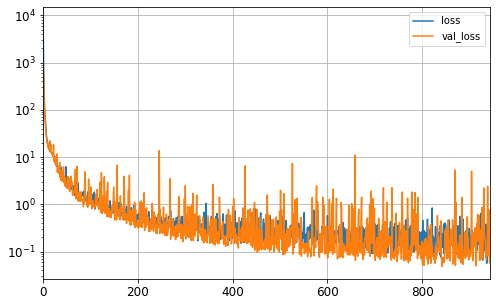

In [55]:
print(history.history.keys())
print('best value: ', autoencoder.evaluate(X_train_pca, X_train_pca, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [56]:
X_reconstructions = autoencoder.predict(X_train_pca)
X_reconstructions = pca.inverse_transform(X_reconstructions)
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  2.195369238521245
mean_abs_error:  0.026052220861696996


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


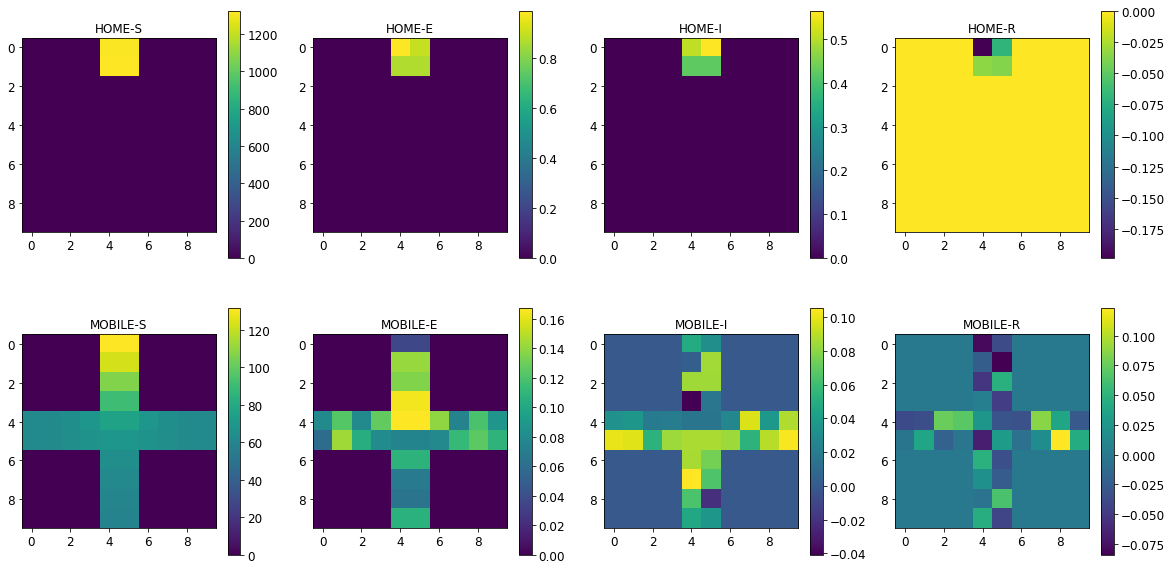

In [57]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

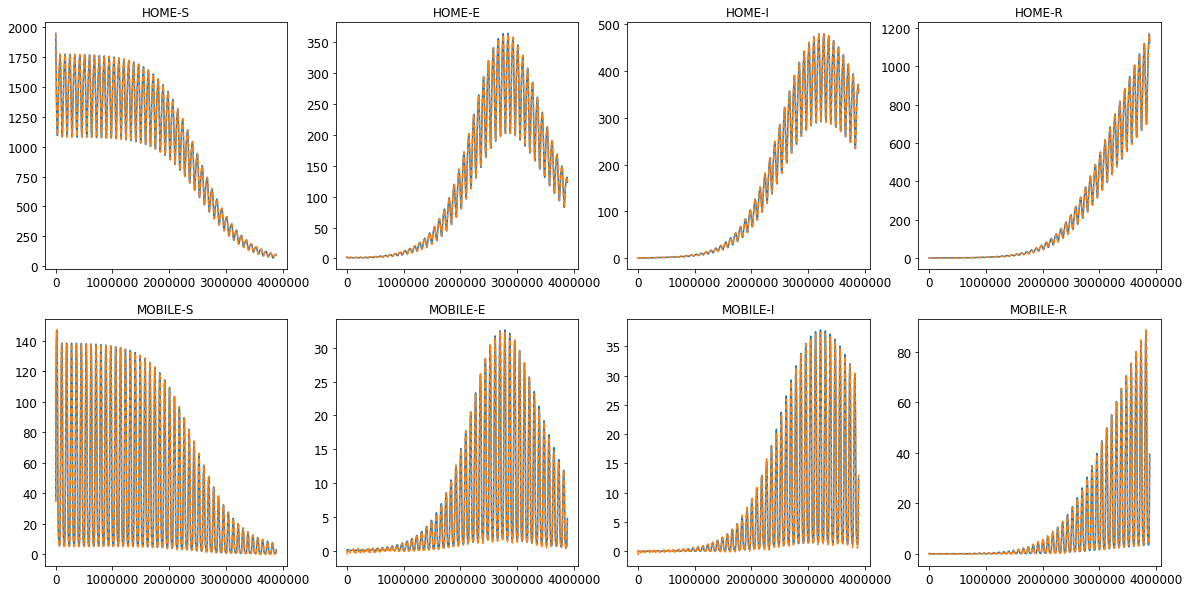

In [58]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

### Convolutional autoencoder

In [59]:
#tf.keras.backend.set_image_data_format('channels_first') 
tf.keras.backend.image_data_format()

'channels_last'

In [60]:
#from sklearn.model_selection import train_test_split
#X_train, X_valid = train_test_split(X_train_3D_norm, test_size=0.2, random_state=42)

X_train = np.moveaxis(X_train_3D_norm, 1, 3) # for channel last

In [61]:
tf.random.set_seed(42)
np.random.seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

conv_encoder = keras.models.Sequential([
    #keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.InputLayer(input_shape=(10, 10, 8)),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="elu"),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="elu"),
    keras.layers.Dense(50, activation="elu"),
    keras.layers.Dense(15)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Dense(50, input_shape=[15], activation="elu"),
    keras.layers.Dense(100, activation="elu"),
    keras.layers.Dense(64*10*10, activation="elu"),
    keras.layers.Reshape(target_shape=(10, 10, 64)),
    keras.layers.Conv2DTranspose(64, kernel_size=3, strides=1, padding="SAME", activation="elu"), 
    keras.layers.Conv2DTranspose(8, kernel_size=3, strides=1, padding="SAME"),
    keras.layers.Reshape([10, 10, 8])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="mse", 
                optimizer=keras.optimizers.Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999))

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 64)        4672      
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 100)               640100    
_________________________________________________________________
dense_19 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_20 (Dense)             (None, 15)                765       
Total params: 650,587
Trainable params: 650,587
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_13"
_________________________________________________________________
Layer (type)            

In [62]:
history = conv_ae.fit(X_train, X_train, 
                      epochs=1000, 
                      validation_data=(X_train, X_train),
                      callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 3s 895us/sample - loss: 0.0434 - val_loss: 0.0080
Epoch 2/1000
3888/3888 [==============================] - 2s 558us/sample - loss: 0.0036 - val_loss: 0.0015
Epoch 3/1000
3888/3888 [==============================] - 2s 522us/sample - loss: 0.0011 - val_loss: 7.2160e-04
Epoch 4/1000
3888/3888 [==============================] - 2s 527us/sample - loss: 6.3083e-04 - val_loss: 4.0945e-04
Epoch 5/1000
3888/3888 [==============================] - 2s 538us/sample - loss: 6.5230e-04 - val_loss: 3.1501e-04
Epoch 6/1000
3888/3888 [==============================] - 2s 535us/sample - loss: 3.0039e-04 - val_loss: 2.3431e-04
Epoch 7/1000
3888/3888 [==============================] - 2s 539us/sample - loss: 3.5650e-04 - val_loss: 1.9783e-04
Epoch 8/1000
3888/3888 [==============================] - 2s 533us/sample - loss: 2.3832e-04 - val_loss: 1.7775e-04
Epoch 9/1000
3888/3888 [====================

Epoch 71/1000
3888/3888 [==============================] - 2s 520us/sample - loss: 1.1961e-05 - val_loss: 1.1199e-05
Epoch 72/1000
3888/3888 [==============================] - 2s 516us/sample - loss: 2.5066e-05 - val_loss: 1.4087e-05
Epoch 73/1000
3888/3888 [==============================] - 2s 522us/sample - loss: 3.0623e-05 - val_loss: 2.6909e-05
Epoch 74/1000
3888/3888 [==============================] - 2s 510us/sample - loss: 2.5317e-05 - val_loss: 1.0060e-05
Epoch 75/1000
3888/3888 [==============================] - 2s 518us/sample - loss: 6.0347e-05 - val_loss: 1.3934e-05
Epoch 76/1000
3888/3888 [==============================] - 2s 517us/sample - loss: 1.4041e-05 - val_loss: 1.2806e-05
Epoch 77/1000
3888/3888 [==============================] - 2s 520us/sample - loss: 2.6030e-05 - val_loss: 1.6550e-05
Epoch 78/1000
3888/3888 [==============================] - 2s 522us/sample - loss: 3.3747e-05 - val_loss: 9.9822e-06
Epoch 79/1000
3888/3888 [==============================] - 2s 52

3888/3888 [==============================] - 2s 520us/sample - loss: 7.0581e-06 - val_loss: 1.0622e-04
Epoch 210/1000
3888/3888 [==============================] - 2s 529us/sample - loss: 1.1246e-05 - val_loss: 7.2725e-06
Epoch 211/1000
3888/3888 [==============================] - 2s 524us/sample - loss: 1.1250e-05 - val_loss: 8.1946e-05
Epoch 212/1000
3888/3888 [==============================] - 2s 522us/sample - loss: 1.2572e-05 - val_loss: 4.7253e-06
Epoch 213/1000
3888/3888 [==============================] - 2s 517us/sample - loss: 7.2925e-06 - val_loss: 4.5228e-06
Epoch 214/1000
3888/3888 [==============================] - 2s 524us/sample - loss: 1.3443e-05 - val_loss: 3.5181e-06
Epoch 215/1000
3888/3888 [==============================] - 2s 523us/sample - loss: 4.9517e-06 - val_loss: 1.3186e-05
Epoch 216/1000
3888/3888 [==============================] - 2s 525us/sample - loss: 1.9197e-05 - val_loss: 4.1599e-06
Epoch 217/1000
3888/3888 [==============================] - 2s 526us/sa

3888/3888 [==============================] - 2s 526us/sample - loss: 4.9543e-06 - val_loss: 2.4473e-06
Epoch 348/1000
3888/3888 [==============================] - 2s 527us/sample - loss: 8.2030e-06 - val_loss: 2.1625e-05
Epoch 349/1000
3888/3888 [==============================] - 2s 512us/sample - loss: 5.2965e-06 - val_loss: 1.3248e-05
Epoch 350/1000
3888/3888 [==============================] - 2s 531us/sample - loss: 3.5001e-06 - val_loss: 3.4564e-06
Epoch 351/1000
3888/3888 [==============================] - 2s 516us/sample - loss: 2.1563e-05 - val_loss: 2.1468e-06
Epoch 352/1000
3888/3888 [==============================] - 2s 524us/sample - loss: 4.2157e-06 - val_loss: 2.5329e-06
Epoch 353/1000
3888/3888 [==============================] - 2s 521us/sample - loss: 3.2324e-06 - val_loss: 2.3022e-06
Epoch 354/1000
3888/3888 [==============================] - 2s 518us/sample - loss: 3.0538e-06 - val_loss: 2.3155e-06
Epoch 355/1000
3888/3888 [==============================] - 2s 517us/sa

3888/3888 [==============================] - 2s 528us/sample - loss: 3.7278e-06 - val_loss: 1.3995e-06
Epoch 486/1000
3888/3888 [==============================] - 2s 512us/sample - loss: 8.2209e-06 - val_loss: 4.0150e-06
Epoch 487/1000
3888/3888 [==============================] - 2s 528us/sample - loss: 3.9177e-06 - val_loss: 4.7908e-06
Epoch 488/1000
3888/3888 [==============================] - 2s 522us/sample - loss: 6.6267e-06 - val_loss: 1.0626e-04
Epoch 489/1000
3888/3888 [==============================] - 2s 525us/sample - loss: 1.0011e-05 - val_loss: 1.6490e-06
Epoch 490/1000
3888/3888 [==============================] - 2s 509us/sample - loss: 2.3579e-06 - val_loss: 2.7779e-06
Epoch 491/1000
3888/3888 [==============================] - 2s 511us/sample - loss: 1.3324e-05 - val_loss: 1.9043e-06
Epoch 492/1000
3888/3888 [==============================] - 2s 528us/sample - loss: 2.3793e-06 - val_loss: 2.4515e-05
Epoch 493/1000
3888/3888 [==============================] - 2s 525us/sa

dict_keys(['loss', 'val_loss'])
best value:  1.3052720110870932e-06


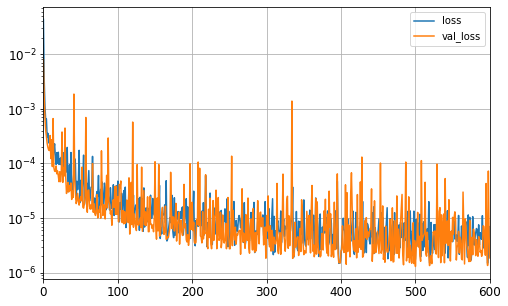

In [63]:
print(history.history.keys())
print('best value: ', conv_ae.evaluate(X_train, X_train, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [64]:
X_reconstructions = conv_ae.predict(X_train)
X_reconstructions = stdscaler.inverse_transform(np.moveaxis(X_reconstructions,3,1).reshape(len(times),len(group)*nl*nc))
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  6.6978759765625
mean_abs_error:  0.015144726812325737


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


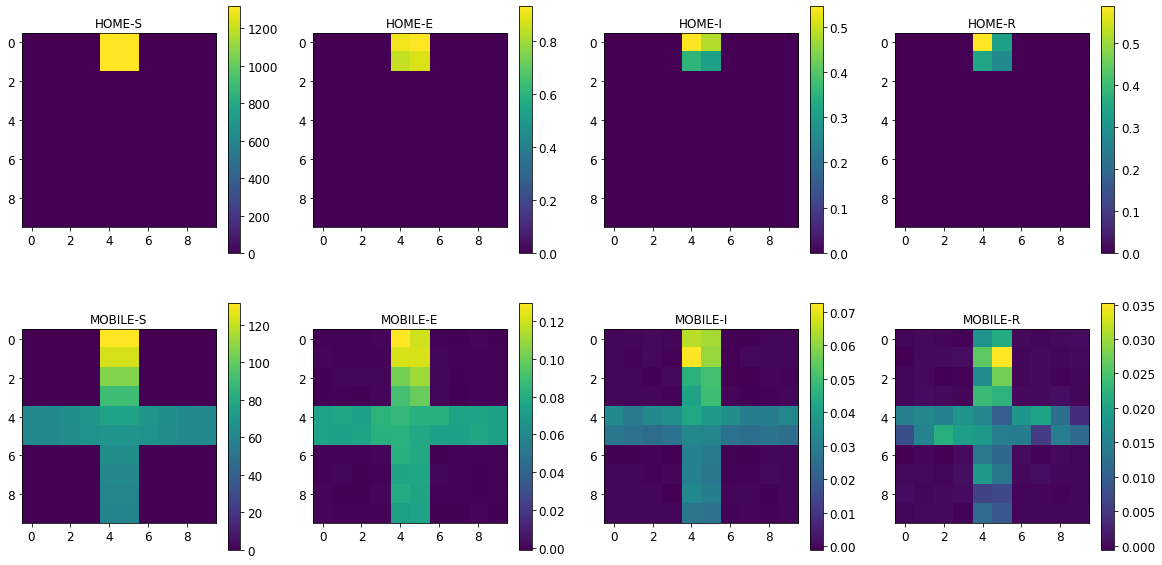

In [65]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

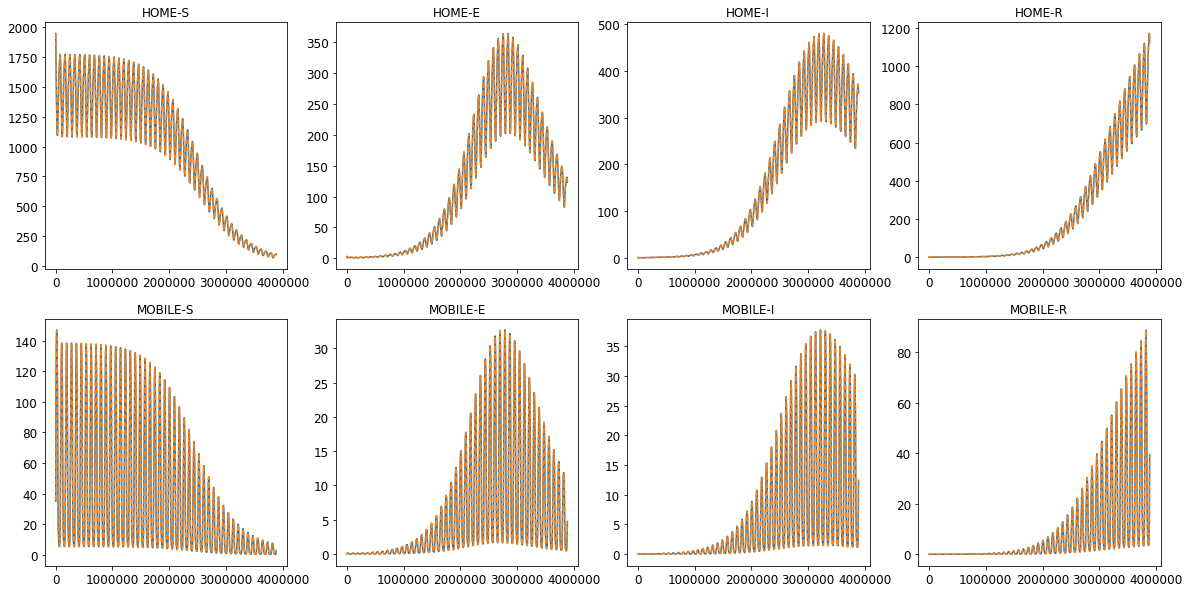

In [66]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)

In [67]:
tf.random.set_seed(42)
np.random.seed(42)

# Need to have validation loss
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0.0,
                                               patience=100,
                                               verbose=2,
                                               restore_best_weights=True)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([10, 10, 8, 1], input_shape=[10, 10, 8]),
    #keras.layers.InputLayer(input_shape=(10, 10, 8)),
    keras.layers.Conv3D(64, kernel_size=3, padding="SAME", activation="elu"),
    keras.layers.MaxPool3D(pool_size=2),
    keras.layers.Conv3D(64, kernel_size=3, padding="SAME", activation="elu"),
    keras.layers.MaxPool3D(pool_size=2),
    keras.layers.Conv3D(64, kernel_size=3, padding="SAME", activation="elu"),
    keras.layers.MaxPool3D(pool_size=2),
    keras.layers.Flatten(),
    #keras.layers.Dense(64, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(15)
])
conv_decoder = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(15)),
    #keras.layers.Dense(64, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(64*1*1*1, activation="elu"),
    keras.layers.Reshape(target_shape=(1, 1, 1, 64)),
    keras.layers.Conv3DTranspose(64, kernel_size=3, strides=2, padding="SAME", activation="elu"),
    keras.layers.Conv3DTranspose(64, kernel_size=3, strides=3, padding="SAME", output_padding=[1,1,0], activation="elu"),
    keras.layers.Conv3DTranspose(1, kernel_size=3, strides=2, padding="SAME"),
    keras.layers.Reshape([10, 10, 8])
])

conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss="mse", 
                optimizer=keras.optimizers.Nadam(lr=0.0003, beta_1=0.9, beta_2=0.999))

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 10, 10, 8, 1)      0         
_________________________________________________________________
conv3d (Conv3D)              (None, 10, 10, 8, 64)     1792      
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 5, 5, 4, 64)       0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 5, 5, 4, 64)       110656    
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 2, 2, 2, 64)       0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 2, 2, 2, 64)       110656    
_________________________________________________________________
max_pooling3d_2 (MaxPooling3 (None, 1, 1, 1, 64)     

In [68]:
history = conv_ae.fit(X_train, X_train, 
                      epochs=1000, 
                      validation_data=(X_train, X_train),
                      callbacks=[early_stopping])

Train on 3888 samples, validate on 3888 samples
Epoch 1/1000
3888/3888 [==============================] - 27s 7ms/sample - loss: 0.0645 - val_loss: 0.0179
Epoch 2/1000
3888/3888 [==============================] - 25s 7ms/sample - loss: 0.0133 - val_loss: 0.0085
Epoch 3/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 0.0037 - val_loss: 0.0013
Epoch 4/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 0.0013 - val_loss: 6.0102e-04
Epoch 5/1000
3888/3888 [==============================] - 25s 7ms/sample - loss: 7.0133e-04 - val_loss: 4.6277e-04
Epoch 6/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 6.3439e-04 - val_loss: 2.6882e-04
Epoch 7/1000
3888/3888 [==============================] - 25s 7ms/sample - loss: 6.1017e-04 - val_loss: 3.0444e-04
Epoch 8/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 3.3062e-04 - val_loss: 2.3250e-04
Epoch 9/1000
3888/3888 [==============================] - 25

3888/3888 [==============================] - 25s 6ms/sample - loss: 4.9834e-05 - val_loss: 9.6887e-05
Epoch 142/1000
3888/3888 [==============================] - 25s 7ms/sample - loss: 1.1577e-05 - val_loss: 4.2448e-06
Epoch 143/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 2.0103e-05 - val_loss: 1.8027e-05
Epoch 144/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 7.2469e-06 - val_loss: 9.7967e-06
Epoch 145/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 9.0995e-05 - val_loss: 4.9933e-06
Epoch 146/1000
3888/3888 [==============================] - 25s 7ms/sample - loss: 4.4109e-06 - val_loss: 3.6676e-06
Epoch 147/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 4.9316e-06 - val_loss: 5.0144e-06
Epoch 148/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.5957e-05 - val_loss: 1.7697e-05
Epoch 149/1000
3888/3888 [==============================] - 25s 6ms/sample - lo

3888/3888 [==============================] - 25s 6ms/sample - loss: 1.7404e-05 - val_loss: 4.7518e-06
Epoch 282/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 7.7398e-06 - val_loss: 4.8252e-06
Epoch 283/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 3.5039e-05 - val_loss: 1.1410e-05
Epoch 284/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 5.9639e-06 - val_loss: 2.7529e-06
Epoch 285/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 2.9719e-06 - val_loss: 4.1002e-06
Epoch 286/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.4980e-05 - val_loss: 1.7641e-05
Epoch 287/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.5673e-05 - val_loss: 2.8693e-06
Epoch 288/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 6.8242e-06 - val_loss: 2.3793e-05
Epoch 289/1000
3888/3888 [==============================] - 25s 6ms/sample - lo

3888/3888 [==============================] - 25s 6ms/sample - loss: 5.5644e-06 - val_loss: 3.4162e-06
Epoch 422/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.1330e-05 - val_loss: 1.8454e-06
Epoch 423/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 5.9444e-06 - val_loss: 9.8210e-06
Epoch 424/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 9.6361e-06 - val_loss: 3.3164e-06
Epoch 425/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 9.5957e-06 - val_loss: 2.8945e-05
Epoch 426/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 2.0282e-05 - val_loss: 1.7842e-05
Epoch 427/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 3.6159e-06 - val_loss: 2.3305e-05
Epoch 428/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.8766e-05 - val_loss: 1.2350e-04
Epoch 429/1000
3888/3888 [==============================] - 25s 6ms/sample - lo

3888/3888 [==============================] - 25s 6ms/sample - loss: 5.8081e-06 - val_loss: 1.9160e-06
Epoch 562/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.1537e-05 - val_loss: 4.3128e-06
Epoch 563/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 2.6935e-06 - val_loss: 2.2248e-06
Epoch 564/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.5494e-05 - val_loss: 1.4273e-06
Epoch 565/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.9940e-05 - val_loss: 4.6616e-06
Epoch 566/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 2.4349e-06 - val_loss: 2.0059e-06
Epoch 567/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 4.0320e-06 - val_loss: 2.2421e-06
Epoch 568/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.5344e-05 - val_loss: 5.3847e-06
Epoch 569/1000
3888/3888 [==============================] - 25s 6ms/sample - lo

3888/3888 [==============================] - 25s 6ms/sample - loss: 2.0496e-05 - val_loss: 2.0991e-06
Epoch 702/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 4.8951e-06 - val_loss: 1.1018e-05
Epoch 703/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 5.8410e-06 - val_loss: 1.1916e-05
Epoch 704/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 7.3333e-06 - val_loss: 1.2308e-05
Epoch 705/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 8.0848e-06 - val_loss: 4.4458e-06
Epoch 706/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 7.5756e-06 - val_loss: 1.2734e-06
Epoch 707/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 3.6885e-06 - val_loss: 2.1342e-05
Epoch 708/1000
3888/3888 [==============================] - 25s 6ms/sample - loss: 1.8995e-05 - val_loss: 1.7240e-06
Epoch 709/1000
3888/3888 [==============================] - 25s 6ms/sample - lo

dict_keys(['loss', 'val_loss'])
best value:  9.027328154536509e-07


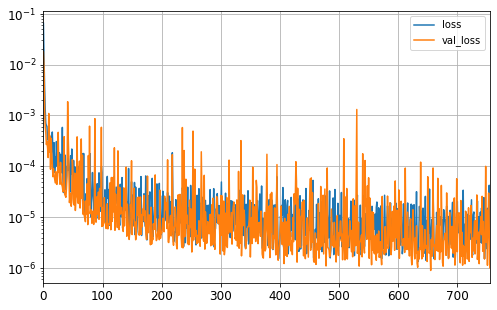

In [69]:
print(history.history.keys())
print('best value: ', conv_ae.evaluate(X_train, X_train, verbose=0))


pd.DataFrame(history.history).plot(figsize=(8, 5), logy=True)
plt.grid()

In [70]:
X_reconstructions = conv_ae.predict(X_train)
X_reconstructions = stdscaler.inverse_transform(np.moveaxis(X_reconstructions,3,1).reshape(len(times),len(group)*nl*nc))
calculateerror(X_train_1D.reshape(len(times),len(groups),nl,nc), 
               X_reconstructions.reshape(len(times),len(groups),nl,nc), 
               groups,
               print_step=0)

max_abs_error:  6.7890625
mean_abs_error:  0.014291764742296214


/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/viluiz/anaconda3/envs/py3ml/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


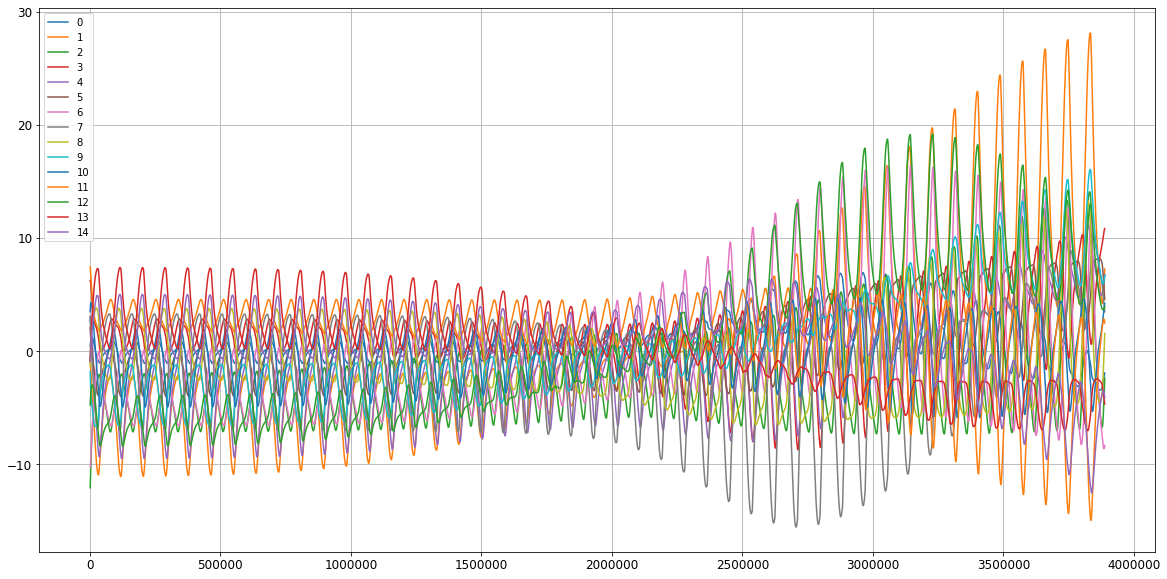

In [110]:
X_train_encoded = conv_ae.layers[0].predict(X_train)

fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(times, X_train_encoded);
ax.grid()
ax.legend(range(15))

In [113]:
from tensorflow.keras.models import load_model
conv_ae.save("conv_ae.h5")
import joblib
joblib.dump(stdscaler, "stdscaler.pkl")
np.savetxt('X_train_encoded.csv', X_train_encoded, delimiter=',') 
np.save('X_train.npy', X_train) 

#...
# conv_ae = load_model("conv_ae.h5") 
# stdscaler = joblib.load("stdscaler.pkl") 
# X_train_compressed = np.loadtxt('X_train_encoded.csv', delimiter=',') 

# X_train_1D = np.loadtxt('X_train_1D.csv', delimiter=',') 
# times  = np.loadtxt('times.csv', delimiter=',') 
# with open('groups.txt') as f:
#     groups = [g.strip() for g in f.readlines()]
    
# X_recovered = conv_ae.layers[1].predict(X_train_compressed)
# X_recovered = stdscaler.inverse_transform(np.moveaxis(X_recovered,3,1).reshape(len(times),len(group)*nl*nc))   

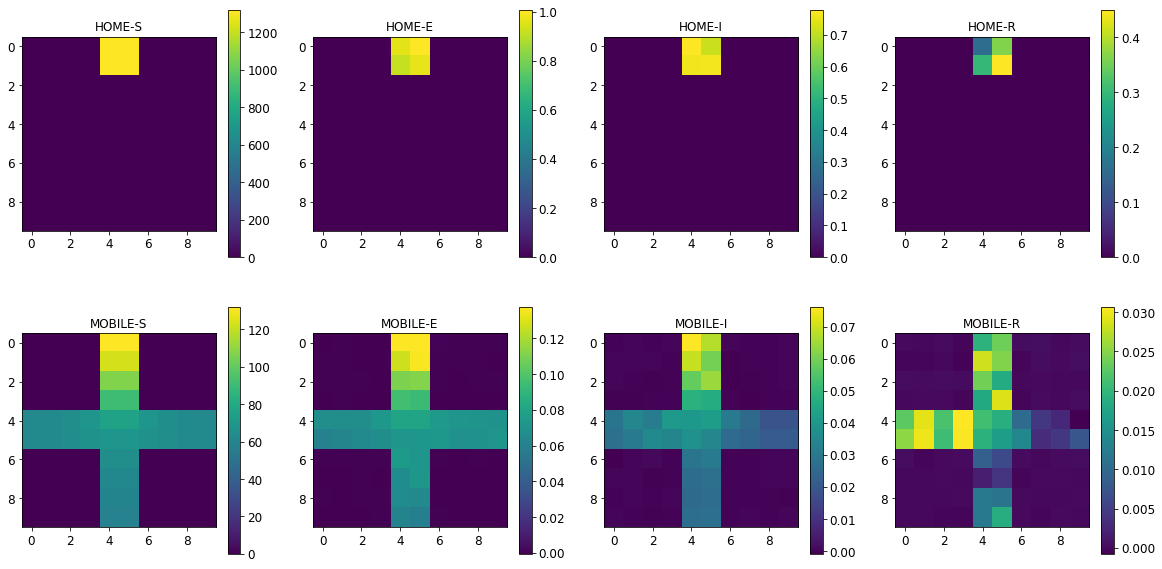

In [71]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    im = ax.flatten()[i].imshow(X_reconstructions.reshape(len(times),len(groups),nl,nc)[100,i,:,:])
    fig.colorbar(im, ax=ax.flatten()[i])
    ax.flatten()[i].set_title(group)

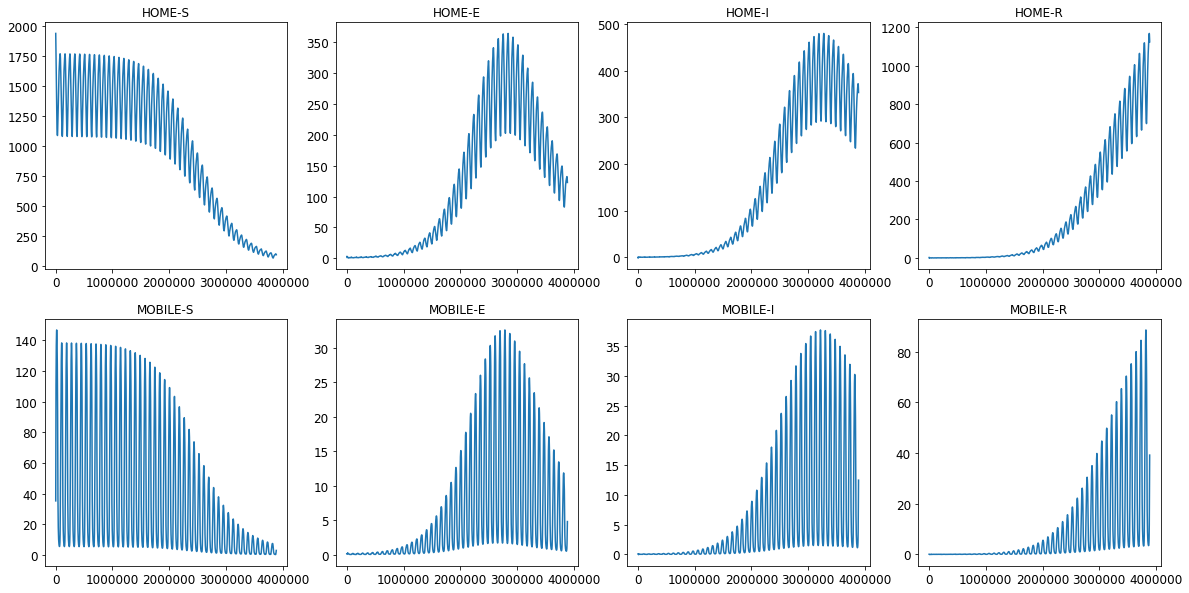

In [72]:
fig, ax = plt.subplots(2,4, figsize=[20,10])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4])
    ax.flatten()[i].set_title(group)

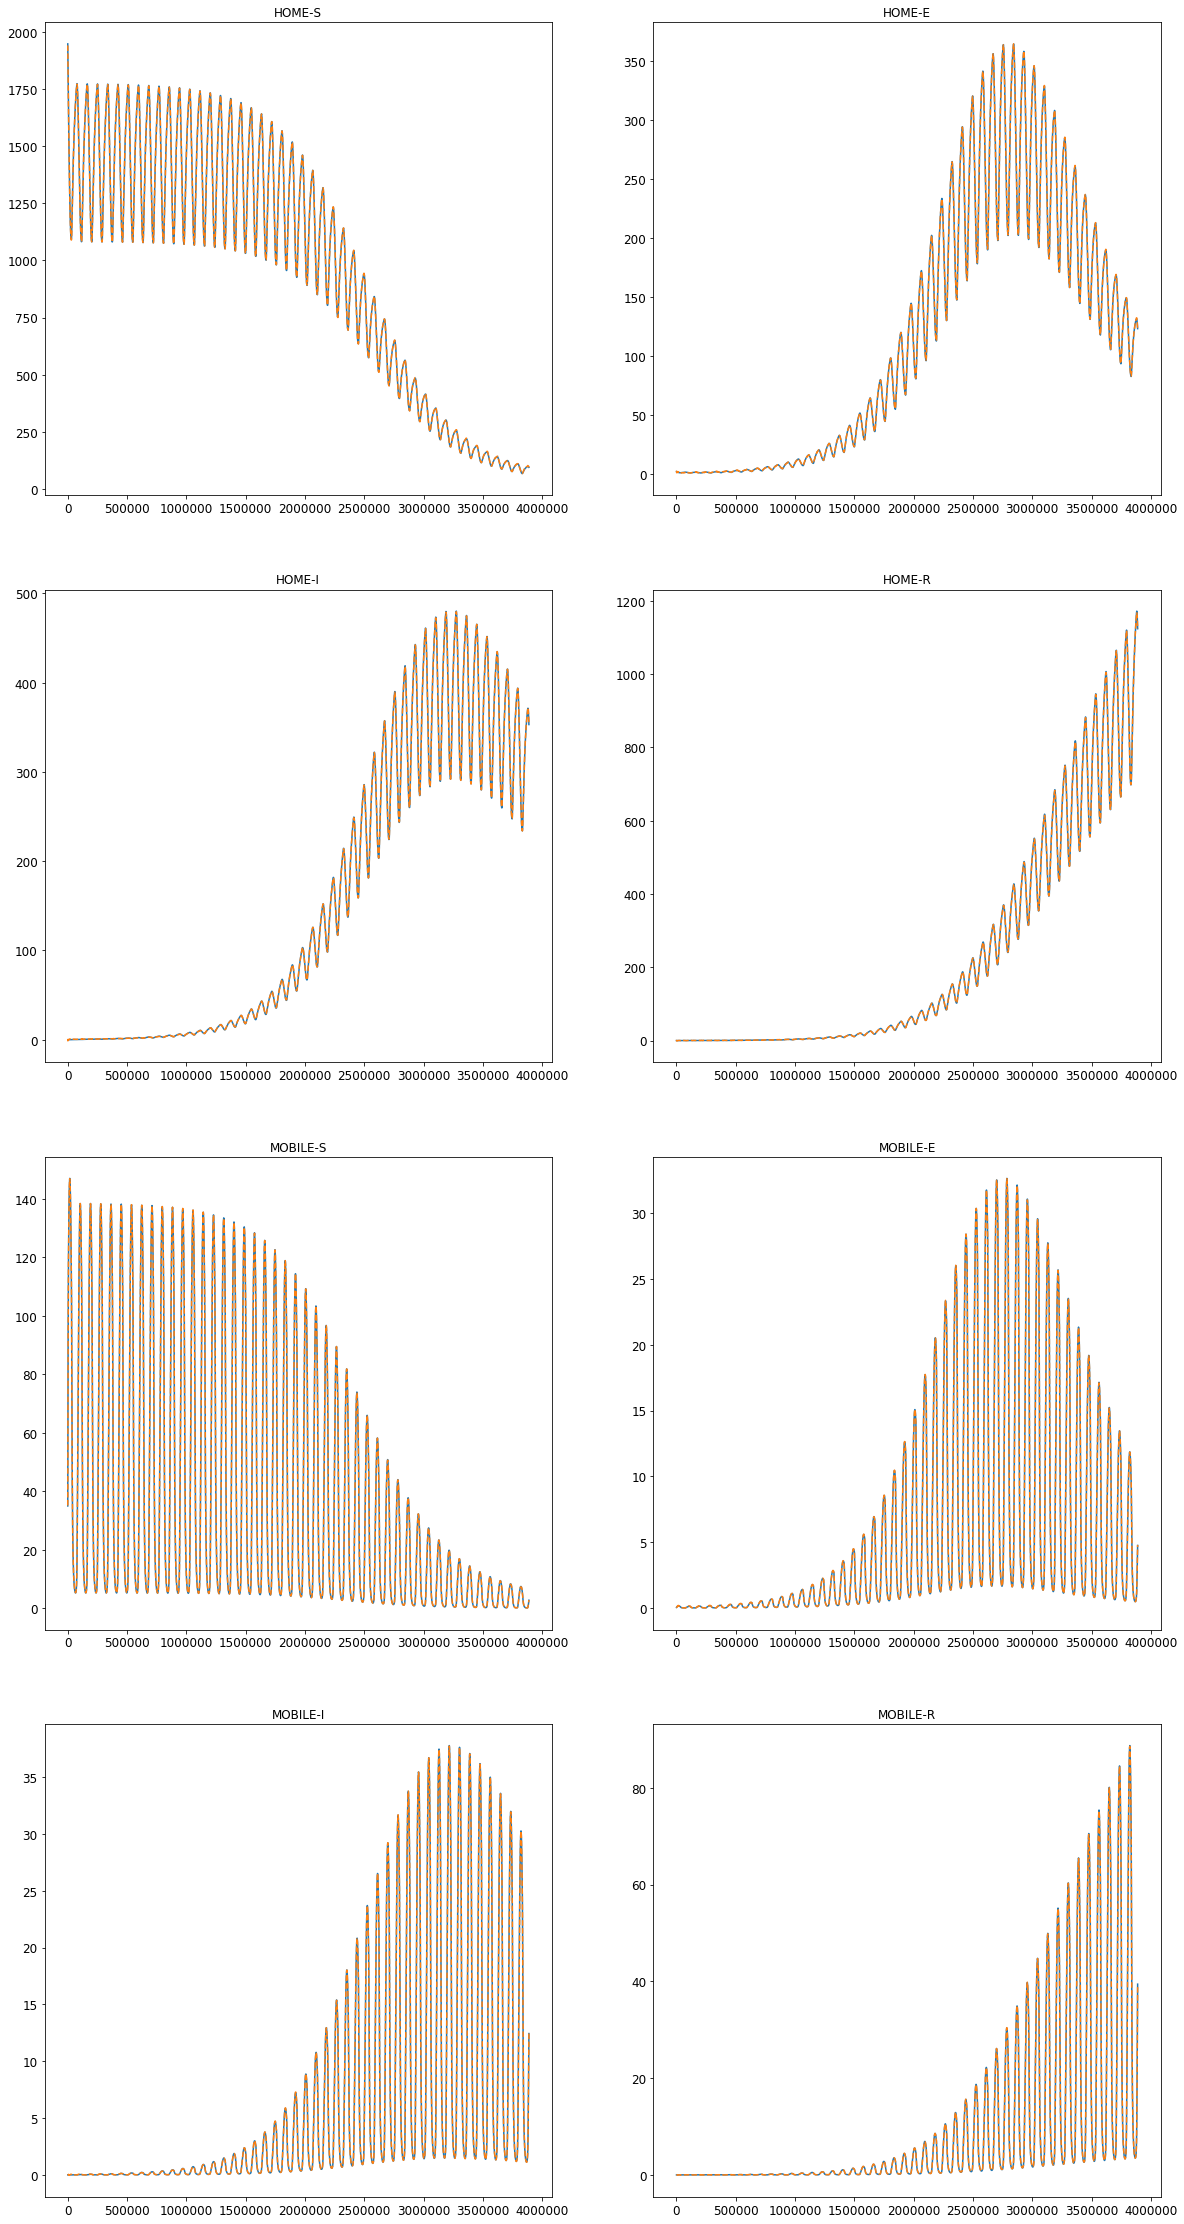

In [93]:
fig, ax = plt.subplots(4,2, figsize=[20,40])
for i, group in enumerate(groups):
    ax.flatten()[i].plot(times, X_train_1D[:,i*nl*nc+4])
    ax.flatten()[i].plot(times, X_reconstructions[:,i*nl*nc+4],'--')
    ax.flatten()[i].set_title(group)